In [2]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [15]:
nr = sc.read_h5ad('./NR/V2L_NR_L23_filter.h5ad')
dr = sc.read_h5ad('./DR/V2L_DR_L23_filter.h5ad')

In [16]:
nr_ptime = pd.read_csv('./ptime/HVG_N_V2L_L23_pseudotime.txt',sep='\t')
dr_ptime = pd.read_csv('./ptime/HVG_D_V2L_L23_pseudotime.txt',sep='\t')

In [6]:
import seaborn as sns
sns.set_theme(style="ticks")

In [17]:
nr_exp=pd.DataFrame(nr.X.todense(),index=nr.obs.index,columns=nr.var.index)
nr_exp = nr_exp.reset_index()
nr_exp['cell_id_match'] = nr_exp['index'].str[:12]
df_ptime_nr = pd.merge(nr_exp, nr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')

# 删除不必要的列并重新设置索引
df_ptime_nr = df_ptime_nr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_nr = df_ptime_nr.dropna()
df_ptime_nr_sorted = df_ptime_nr.sort_values(by='velocity_pseudotime', ascending=True)


dr_exp=pd.DataFrame(dr.X.todense(),index=dr.obs.index,columns=dr.var.index)
dr_exp = dr_exp.reset_index()
dr_exp['cell_id_match'] = dr_exp['index'].str[:12]
df_ptime_dr = pd.merge(dr_exp, dr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')

# 删除不必要的列并重新设置索引
df_ptime_dr = df_ptime_dr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_dr = df_ptime_dr.dropna()
df_ptime_dr_sorted = df_ptime_dr.sort_values(by='velocity_pseudotime', ascending=True)

df_ptime_nr_sorted = df_ptime_nr.sort_values(by='velocity_pseudotime', ascending=True)
df_ptime_dr_sorted = df_ptime_dr.sort_values(by='velocity_pseudotime', ascending=True)
df_ptime_nr_sorted['index'] = range(df_ptime_nr_sorted.shape[0])
df_ptime_nr_sorted['index_bin'] = pd.cut(df_ptime_nr_sorted['index'], bins=np.arange(0, 4238 + 4238/100, 4238/100))
bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
df_ptime_dr_sorted['index'] = range(df_ptime_dr_sorted.shape[0])
df_ptime_dr_sorted['index_bin'] = pd.cut(df_ptime_dr_sorted['index'], bins=np.arange(0, 4017 + 4017/100, 4017/100))
bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()
bin_means_nr['index'] = range(bin_means_nr.shape[0])
bin_means_dr['index'] = range(bin_means_dr.shape[0])

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_1461/1280202486.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_1461/1280202486.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()


In [6]:
pc_gene = pd.read_csv('V2L_L23_Lasso_PC1rank.xls',sep='\t')

In [7]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]

In [8]:
bin_means_nr_ = bin_means_nr
bin_means_nr_.index = list(bin_means_nr_['index'])
del bin_means_nr_['index']
bin_means_nr_T = bin_means_nr_.T

bin_means_dr_ = bin_means_dr
bin_means_dr_.index = list(bin_means_dr_['index'])
del bin_means_dr_['index']
bin_means_dr_T = bin_means_dr_.T

slope_ =[]
for i in range(bin_means_dr_T.shape[0]):
    x = np.array(bin_means_dr.index)
    y = np.array(bin_means_dr[bin_means_dr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_dr_T['slope'] = slope_

slope_ =[]
for i in range(bin_means_nr_T.shape[0]):
    x = np.array(bin_means_nr.index)
    y = np.array(bin_means_nr[bin_means_nr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_nr_T['slope'] = slope_

In [9]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_dr_T.index)
slope_df['slope']= list(bin_means_dr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(dr_pc_gene.shape[0]):
    if dr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][dr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
dr_pc_gene['slope'] = slope
dr_pc_gene = dr_pc_gene[dr_pc_gene['slope'] != 'No']
dr_pc_gene['slope_abs'] = dr_pc_gene['slope'].abs()

dr_pc_gene_filter = dr_pc_gene[dr_pc_gene['dr_pc_lasso'] != 4000]
###
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_nr_T.index)
slope_df['slope']= list(bin_means_nr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(nr_pc_gene.shape[0]):
    if nr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][nr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
nr_pc_gene['slope'] = slope
nr_pc_gene = nr_pc_gene[nr_pc_gene['slope'] != 'No']
nr_pc_gene['slope_abs'] = nr_pc_gene['slope'].abs()

nr_pc_gene_filter = nr_pc_gene[nr_pc_gene['nr_pc_lasso'] != 4000]

nr_pc_gene_filter['Cond'] = 'NR'
dr_pc_gene_filter['Cond'] = 'DR'

nr_pc_gene_filter['Rank'] = nr_pc_gene_filter['nr_pc_lasso']
dr_pc_gene_filter['Rank'] = dr_pc_gene_filter['dr_pc_lasso']
del nr_pc_gene_filter['nr_pc_lasso']
del dr_pc_gene_filter['dr_pc_lasso']
df_merge_pc_gene = pd.concat([nr_pc_gene_filter, dr_pc_gene_filter])

df_merge_pc_gene['slope_abs'] = df_merge_pc_gene['slope_abs']*100

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_36067/694031600.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_36067/694031600.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_36067/694031600.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [10]:
df_merge_pc_gene

Gene     logFC     slope  slope_abs Cond  Rank
0      Nrbp2  0.406365  0.000683   0.068280   NR   291
1      Unc5c -1.247012 -0.001395   0.139527   NR   590
2     Kif13b -0.400450 -0.000177   0.017745   NR   655
3       Nfia  1.287674  0.001236   0.123644   NR   178
4    Fam210a  0.490547  0.000678   0.067817   NR   441
..       ...       ...       ...        ...  ...   ...
739    Ptpre  0.217805  0.002348   0.234801   DR   156
740   Tyrobp -0.811531  0.000085   0.008466   DR  1428
741   Zfp608  0.282400  0.002920   0.291968   DR   134
742    Lrrn1 -1.102098  0.001346   0.134622   DR   224
744     Fbn2 -0.603277 -0.001473   0.147275   DR   286

[1347 rows x 6 columns]

In [11]:
df_NR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'NR']
df_DR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'DR']

In [12]:
df_NR['slope_abs'].min()

8.776808532552757e-05

In [13]:
df_NR['slope_abs'].max()

2.2543129553996586

In [14]:
df_NR_0 = df_NR[df_NR['slope_abs'] > 1]
df_NR_1 = df_NR[(df_NR['slope_abs'] > 0.5) & (df_NR['slope_abs'] <= 1) ]
df_NR_2 = df_NR[(df_NR['slope_abs'] > 0.1) & (df_NR['slope_abs'] <= 0.5) ]
df_NR_3 = df_NR[(df_NR['slope_abs'] > 0.02) & (df_NR['slope_abs'] <= 0.1) ]
df_NR_4 = df_NR[df_NR['slope_abs'] <= 0.02]

df_DR_0 = df_DR[df_DR['slope_abs'] > 1]
df_DR_1 = df_DR[(df_DR['slope_abs'] > 0.5) & (df_DR['slope_abs'] <= 1) ]
df_DR_2 = df_DR[(df_DR['slope_abs'] > 0.1) & (df_DR['slope_abs'] <= 0.5) ]
df_DR_3 = df_DR[(df_DR['slope_abs'] > 0.02) & (df_DR['slope_abs'] <= 0.1) ]
df_DR_4 = df_DR[df_DR['slope_abs'] <= 0.02]

拟合参数：a = 18.971273323094753, b = -2.005393704491528


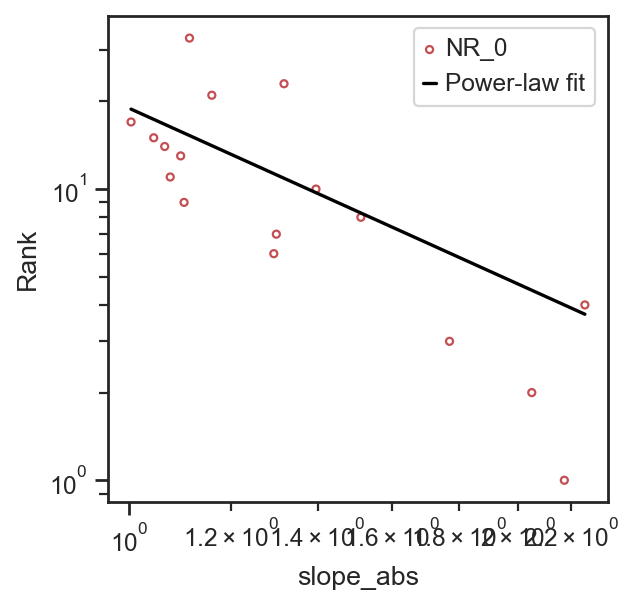

In [15]:
Rank = np.array(df_NR_0['Rank']+1)
slope_abs = np.array(df_NR_0['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR_0', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 11.966027907440452, b = -2.808246286139443


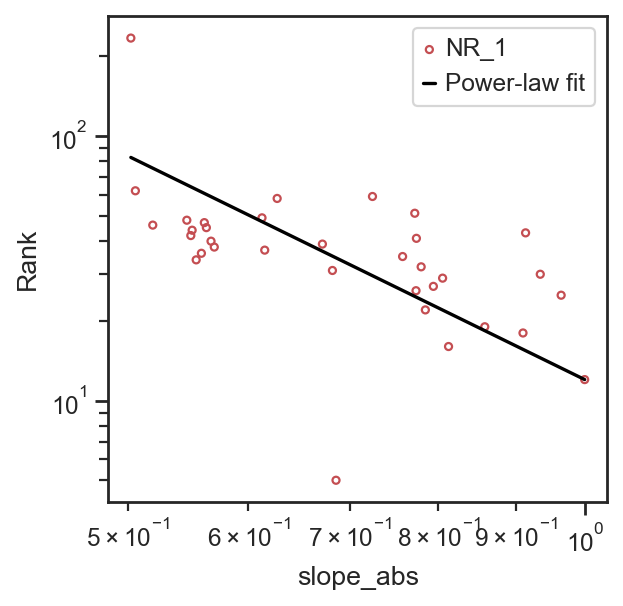

In [16]:
Rank = np.array(df_NR_1['Rank']+1)
slope_abs = np.array(df_NR_1['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR_1', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 43.426238624416875, b = -0.8941690791839817


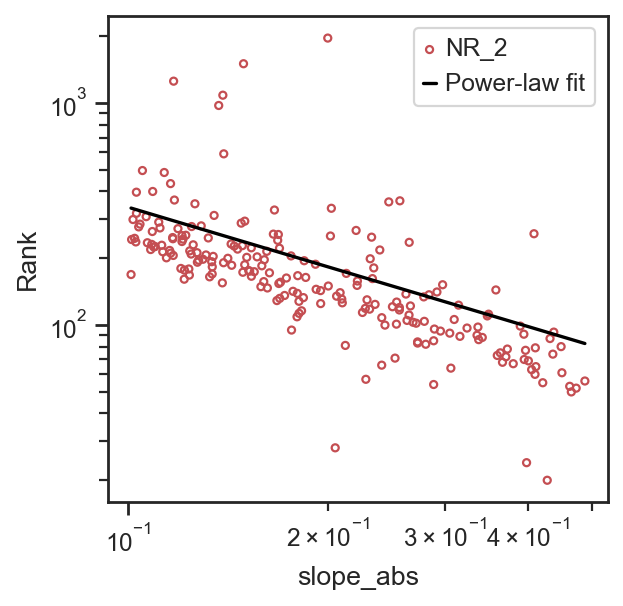

In [17]:
Rank = np.array(df_NR_2['Rank']+1)
slope_abs = np.array(df_NR_2['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR_2', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 67.3997854763321, b = -0.6552971833330101


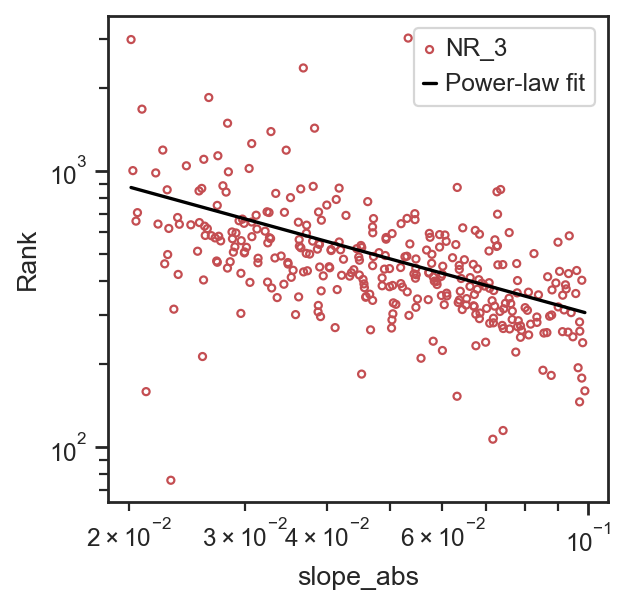

In [18]:
Rank = np.array(df_NR_3['Rank']+1)
slope_abs = np.array(df_NR_3['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR_3', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 626.0909604030837, b = -0.09357255537730695


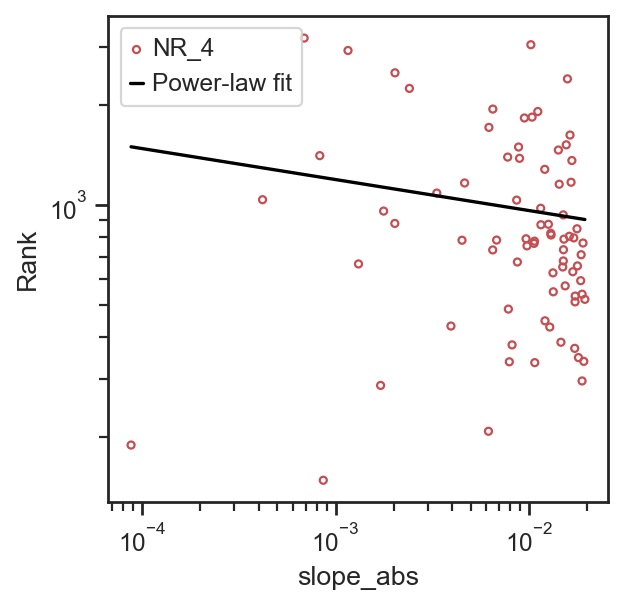

In [19]:
Rank = np.array(df_NR_4['Rank']+1)
slope_abs = np.array(df_NR_4['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR_4', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

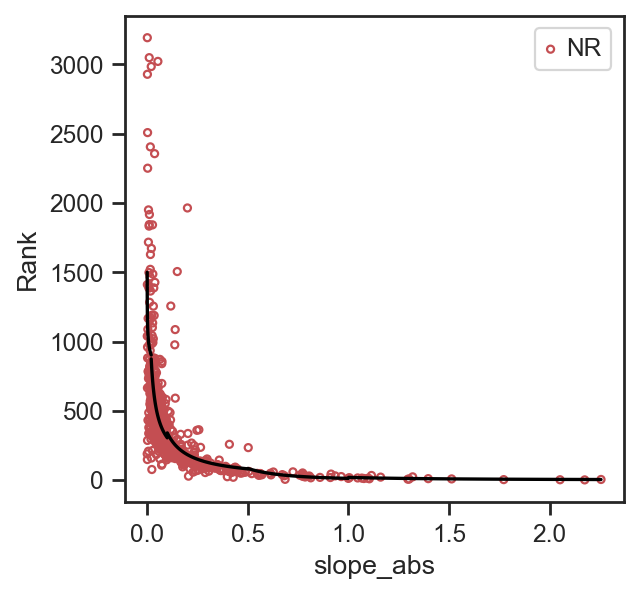

In [20]:
Rank = np.array(df_NR['Rank']+1)
slope_abs = np.array(df_NR['slope_abs'])

# 拟合参数
nr_0_a = 18.971
nr_0_b = -2.0053
nr_1_a = 11.9660
nr_1_b = -2.8082
nr_2_a = 43.4262
nr_2_b = -0.8941
nr_3_a = 67.3997
nr_3_b = -0.6552
nr_4_a = 626.090
nr_4_b = -0.0935
# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR', color='r', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.5, 1, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.1, 0.5, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(0.02, 0.1, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
nr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_4 = power_law(nr_x_fit_4, nr_4_a, nr_4_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.plot(nr_x_fit_4, nr_y_fit_4, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
#plt.ylim(0,3000)
#plt.xscale('log')  # 对x轴进行对数缩放
#plt.yscale('log')  # 对y轴进行对数缩放

plt.show()

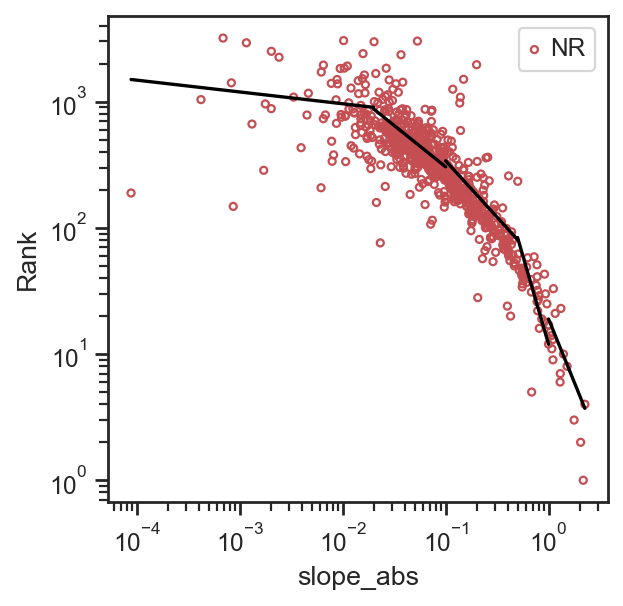

In [21]:
# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR', color='r', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.5, 1, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.1, 0.5, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(0.02, 0.1, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
nr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_4 = power_law(nr_x_fit_4, nr_4_a, nr_4_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.plot(nr_x_fit_4, nr_y_fit_4, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
#plt.ylim(0,3000)
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放

plt.show()

In [27]:
pc_gene

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
0      Nrbp2          291          386    1.325342  0.406365  0.000683   
1      Unc5c          590          248    0.421320 -1.247012 -0.001395   
2     Kif13b          655          496    0.757622 -0.400450 -0.000177   
3       Nfia          178          436    2.441341  1.287674  0.001236   
4    Fam210a          441          620    1.404977  0.490547  0.000678   
..       ...          ...          ...         ...       ...       ...   
740   Tyrobp         2507         1428    0.569777 -0.811531 -0.000020   
741   Zfp608          110          134    1.216216  0.282400  0.002650   
742    Lrrn1          482          224    0.465839 -1.102098  0.000315   
743    Oprm1          241         4000   16.533058  4.047282 -0.000581   
744     Fbn2          435          286    0.658257 -0.603277 -0.000960   

     NR_slope_abs  DR_slope  DR_slope_abs  
0        0.068280  0.000523      0.052253  
1        0.139527 -0.002331      0.233134  
2        0.017745  0.000384      0.038362  
3        0.123644  0.000772      0.077192  
4        0.067817 -0.000487      0.048660  
..            ...       ...           ...  
740      0.002026  0.000085      0.008466  
741      0.264957  0.002920      0.291968  
742      0.031453  0.001346      0.134622  
743      0.058077 -0.001926      0.192584  
744      0.095999 -0.001473      0.147275  

[745 rows x 9 columns]

In [25]:
del pc_gene['Unnamed: 0']

In [26]:
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_nr_T.index)
slope_df['slope']= list(bin_means_nr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][pc_gene['Gene'][i]])
    else:
        slope.append('No')
pc_gene['NR_slope'] = slope
pc_gene['NR_slope_abs'] = (pc_gene['NR_slope']*100).abs()
###
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_dr_T.index)
slope_df['slope']= list(bin_means_dr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][pc_gene['Gene'][i]])
    else:
        slope.append('No')
pc_gene['DR_slope'] = slope
pc_gene['DR_slope_abs'] = (pc_gene['DR_slope']*100).abs()



In [29]:
NR_predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['NR_slope_abs'][i] >1:
        rank = 18.9712* np.power(pc_gene['NR_slope_abs'][i], -2.0053)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] >0.5:
        rank = 11.9660* np.power(pc_gene['NR_slope_abs'][i], -2.8082)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] >0.1:
        rank = 43.4262* np.power(pc_gene['NR_slope_abs'][i],-0.8941)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] > 0.02:
        rank = 67.3997* np.power(pc_gene['NR_slope_abs'][i],-0.6552)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] <= 0.02:
        rank = 626.0909* np.power(pc_gene['NR_slope_abs'][i],-0.0935)
        NR_predicted_rank.append(rank)
pc_gene['NR_predicted_rank'] = NR_predicted_rank

In [30]:
pc_gene

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
0      Nrbp2          291          386    1.325342  0.406365  0.000683   
1      Unc5c          590          248    0.421320 -1.247012 -0.001395   
2     Kif13b          655          496    0.757622 -0.400450 -0.000177   
3       Nfia          178          436    2.441341  1.287674  0.001236   
4    Fam210a          441          620    1.404977  0.490547  0.000678   
..       ...          ...          ...         ...       ...       ...   
740   Tyrobp         2507         1428    0.569777 -0.811531 -0.000020   
741   Zfp608          110          134    1.216216  0.282400  0.002650   
742    Lrrn1          482          224    0.465839 -1.102098  0.000315   
743    Oprm1          241         4000   16.533058  4.047282 -0.000581   
744     Fbn2          435          286    0.658257 -0.603277 -0.000960   

     NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  
0        0.068280  0.000523      0.052253         391.226190  
1        0.139527 -0.002331      0.233134         252.646941  
2        0.017745  0.000384      0.038362         912.742584  
3        0.123644  0.000772      0.077192         281.475942  
4        0.067817 -0.000487      0.048660         392.975872  
..            ...       ...           ...                ...  
740      0.002026  0.000085      0.008466        1118.082060  
741      0.264957  0.002920      0.291968         142.393464  
742      0.031453  0.001346      0.134622         650.107980  
743      0.058077 -0.001926      0.192584         434.994147  
744      0.095999 -0.001473      0.147275         312.950286  

[745 rows x 10 columns]

拟合参数：a = 26.722470938287614, b = -2.508628424901035


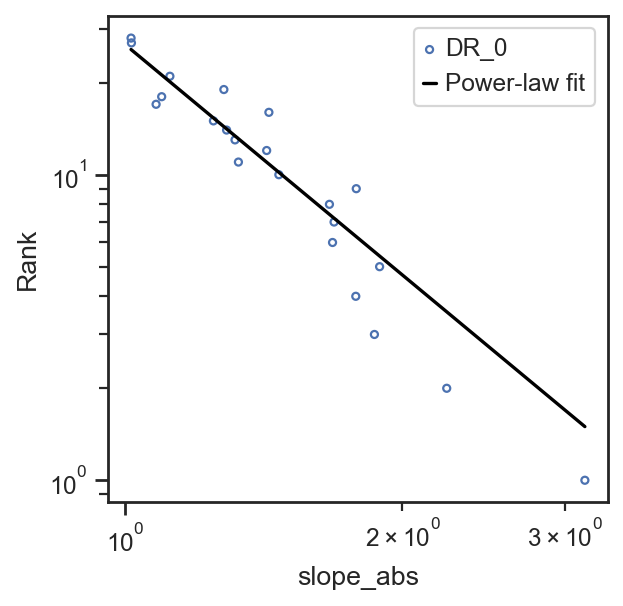

In [31]:
Rank = np.array(df_DR_0['Rank']+1)
slope_abs = np.array(df_DR_0['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR_0', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 24.944606830168908, b = -1.595130106387475


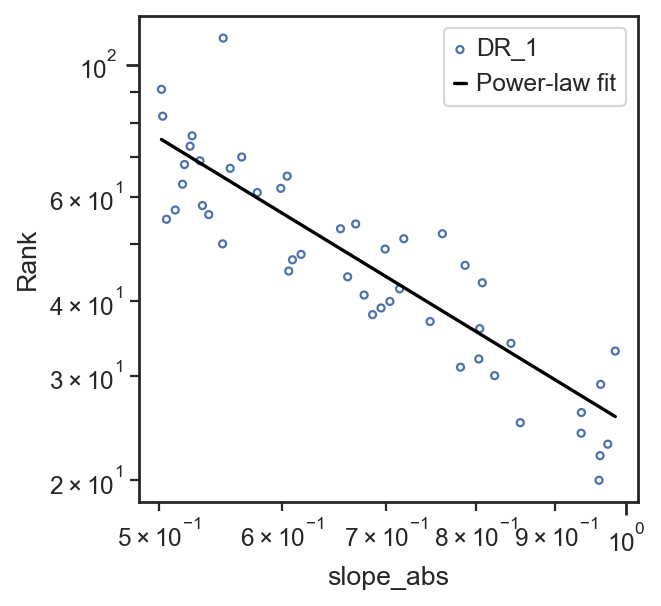

In [33]:
Rank = np.array(df_DR_1['Rank']+1)
slope_abs = np.array(df_DR_1['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR_1', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 42.67158833847648, b = -0.8898695601215181


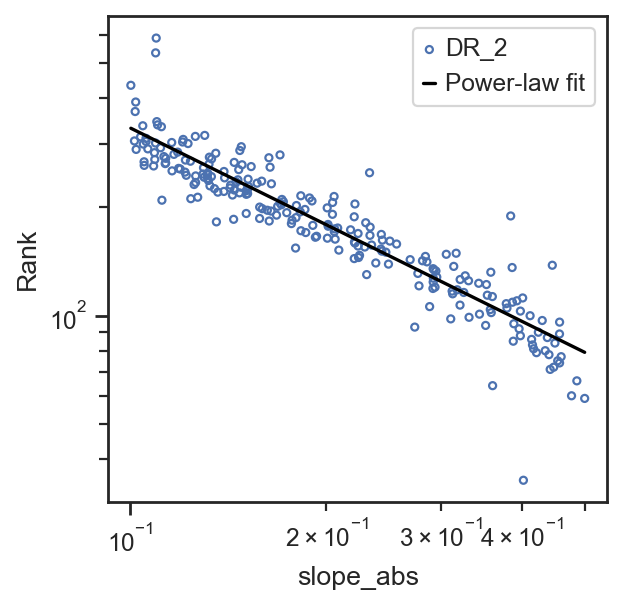

In [34]:
Rank = np.array(df_DR_2['Rank']+1)
slope_abs = np.array(df_DR_2['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR_2', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 70.99579183979597, b = -0.6800034310398623


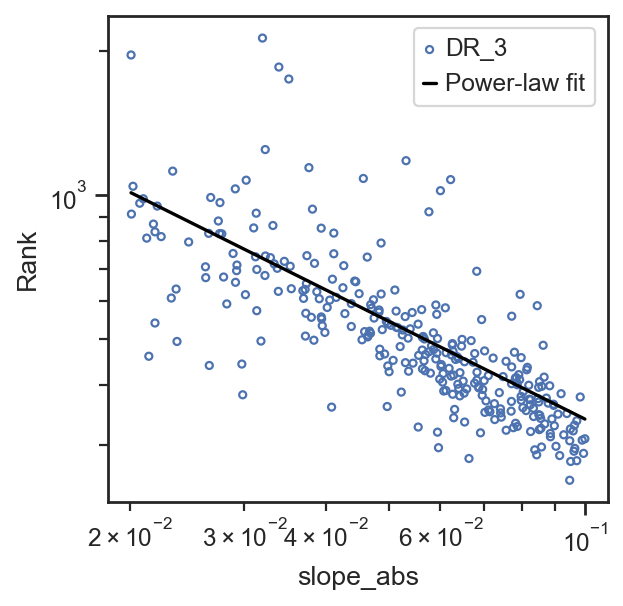

In [35]:
Rank = np.array(df_DR_3['Rank']+1)
slope_abs = np.array(df_DR_3['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR_3', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

拟合参数：a = 482.0157124021118, b = -0.22507806967643823


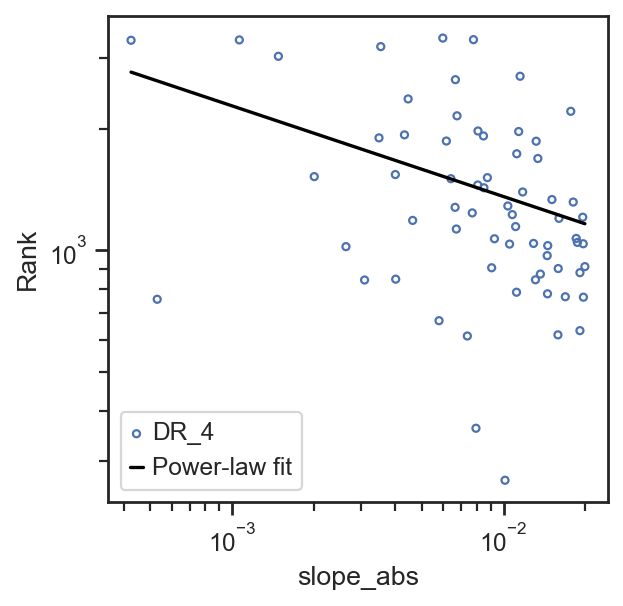

In [36]:
Rank = np.array(df_DR_4['Rank']+1)
slope_abs = np.array(df_DR_4['slope_abs'])
from scipy.optimize import curve_fit


# 定义幂律函数
def power_law(x, a, b):
    return a * np.power(x, b)

# 使用curve_fit进行拟合
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# 输出拟合参数
print(f"拟合参数：a = {a}, b = {b}")

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR_4', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放
plt.show()

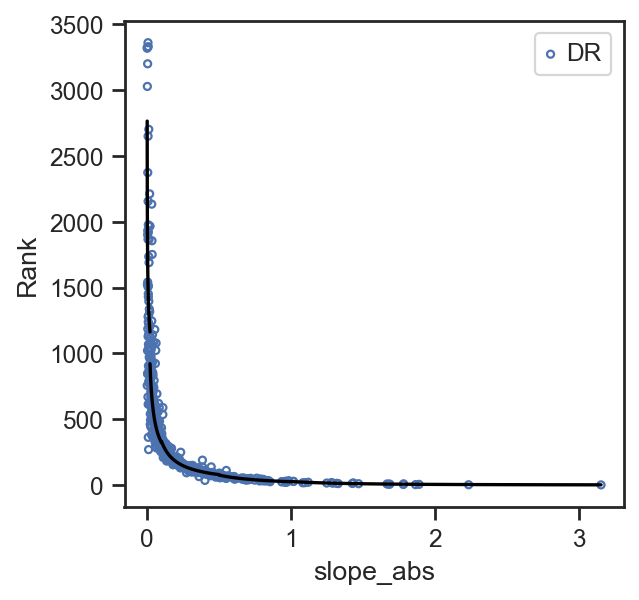

In [38]:
Rank = np.array(df_DR['Rank']+1)
slope_abs = np.array(df_DR['slope_abs'])

# 拟合参数

nr_0_a = 26.7224
nr_0_b = -2.5086
nr_1_a = 24.9446
nr_1_b = -1.5951
nr_2_a = 42.6715
nr_2_b = -0.8898
nr_3_a = 70.9957
nr_3_b = -0.6552
nr_4_a = 482.0157
nr_4_b = -0.2250

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR', color='b', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.5, 1, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.1, 0.5, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(0.02, 0.1, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
nr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_4 = power_law(nr_x_fit_4, nr_4_a, nr_4_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.plot(nr_x_fit_4, nr_y_fit_4, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
#plt.ylim(0,3000)
#plt.xscale('log')  # 对x轴进行对数缩放
#plt.yscale('log')  # 对y轴进行对数缩放

plt.show()

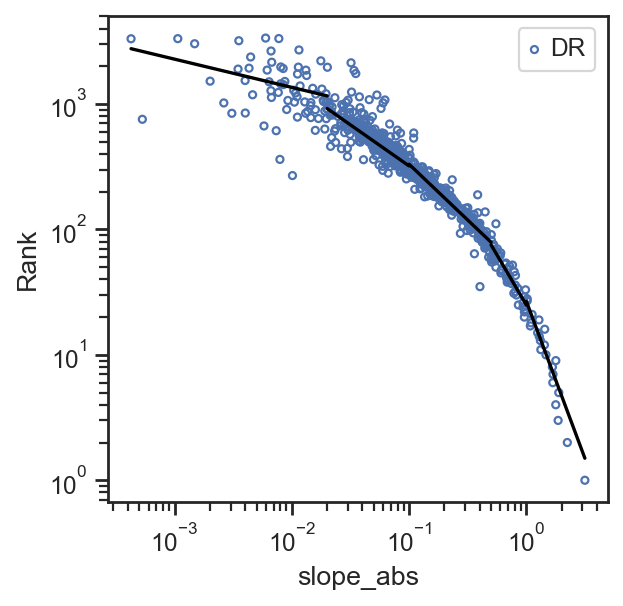

In [39]:
# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR', color='b', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.5, 1, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.1, 0.5, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(0.02, 0.1, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
nr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_4 = power_law(nr_x_fit_4, nr_4_a, nr_4_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.plot(nr_x_fit_4, nr_y_fit_4, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
#plt.ylim(0,3000)
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放

plt.show()

In [43]:
DR_predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['DR_slope_abs'][i] >1:
        rank = 26.7224* np.power(pc_gene['DR_slope_abs'][i], -2.5086)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] >0.5:
        rank = 24.9446* np.power(pc_gene['DR_slope_abs'][i], -1.5951)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] >0.1:
        rank = 42.671* np.power(pc_gene['DR_slope_abs'][i],-0.8898)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] > 0.02:
        rank = 70.9957* np.power(pc_gene['DR_slope_abs'][i],-0.6800)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] <= 0.02:
        rank = 482.0157* np.power(pc_gene['DR_slope_abs'][i],-0.2250)
        DR_predicted_rank.append(rank)
pc_gene['DR_predicted_rank'] = DR_predicted_rank

In [45]:
pc_gene

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
0      Nrbp2          291          386    1.325342  0.406365  0.000683   
1      Unc5c          590          248    0.421320 -1.247012 -0.001395   
2     Kif13b          655          496    0.757622 -0.400450 -0.000177   
3       Nfia          178          436    2.441341  1.287674  0.001236   
4    Fam210a          441          620    1.404977  0.490547  0.000678   
..       ...          ...          ...         ...       ...       ...   
740   Tyrobp         2507         1428    0.569777 -0.811531 -0.000020   
741   Zfp608          110          134    1.216216  0.282400  0.002650   
742    Lrrn1          482          224    0.465839 -1.102098  0.000315   
743    Oprm1          241         4000   16.533058  4.047282 -0.000581   
744     Fbn2          435          286    0.658257 -0.603277 -0.000960   

     NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
0        0.068280  0.000523      0.052253         391.226190   
1        0.139527 -0.002331      0.233134         252.646941   
2        0.017745  0.000384      0.038362         912.742584   
3        0.123644  0.000772      0.077192         281.475942   
4        0.067817 -0.000487      0.048660         392.975872   
..            ...       ...           ...                ...   
740      0.002026  0.000085      0.008466        1118.082060   
741      0.264957  0.002920      0.291968         142.393464   
742      0.031453  0.001346      0.134622         650.107980   
743      0.058077 -0.001926      0.192584         434.994147   
744      0.095999 -0.001473      0.147275         312.950286   

     DR_predicted_rank  
0           528.345085  
1           155.896836  
2           651.898857  
3           405.211725  
4           554.571983  
..                 ...  
740        1410.385256  
741         127.608040  
742         254.123256  
743         184.789973  
744         234.601801  

[745 rows x 11 columns]

In [ ]:
df_NR_0 = df_NR[df_NR['slope_abs'] > 1]
df_NR_1 = df_NR[(df_NR['slope_abs'] > 0.5) & (df_NR['slope_abs'] <= 1) ]
df_NR_2 = df_NR[(df_NR['slope_abs'] > 0.1) & (df_NR['slope_abs'] <= 0.5) ]
df_NR_3 = df_NR[(df_NR['slope_abs'] > 0.02) & (df_NR['slope_abs'] <= 0.1) ]
df_NR_4 = df_NR[df_NR['slope_abs'] <= 0.02]
#NR
a = 18.971273323094753, b = -2.005393704491528
a = 11.966027907440452, b = -2.808246286139443
a = 43.426238624416875, b = -0.8941690791839817
a = 67.3997854763321, b = -0.6552971833330101
a = 626.0909604030837, b = -0.09357255537730695

##DR
a = 26.722470938287614, b = -2.508628424901035
a = 24.944606830168908, b = -1.595130106387475
a = 42.67158833847648, b = -0.8898695601215181
a = 70.99579183979597, b = -0.6800034310398623
a = 482.0157124021118, b = -0.22507806967643823

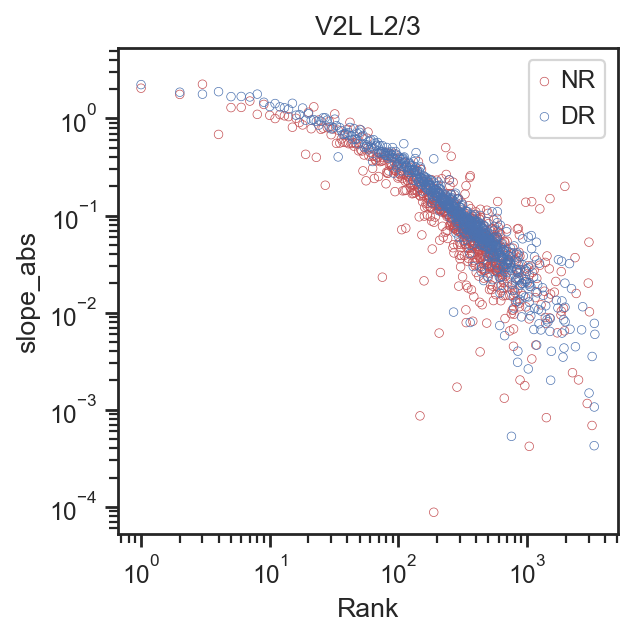

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))

# 绘制NR数据的散点图
sns.scatterplot(
    data=df_NR, 
    x='Rank', 
    y='slope_abs',
    s=15, 
    marker='o', 
    facecolor='none', 
    edgecolor='r', 
    ax=ax,
    label='NR'
)

# 绘制DR数据的散点图
sns.scatterplot(
    data=df_DR, 
    x='Rank', 
    y='slope_abs',
    s=15, 
    marker='o', 
    facecolor='none', 
    edgecolor='b', 
    ax=ax,
    label='DR'
)
plt.xlabel('Rank')
plt.ylabel('slope_abs')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('V2L L2/3')
plt.show()

In [49]:
predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['nr_pc_lasso'][i] != 4000:
        predicted_rank.append(pc_gene['nr_pc_lasso'][i])
    else:
        predicted_rank.append(pc_gene['NR_predicted_rank'][i])
pc_gene['NR_predicted_rank_final'] = predicted_rank

predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['dr_pc_lasso'][i] != 4000:
        predicted_rank.append(pc_gene['dr_pc_lasso'][i])
    else:
        predicted_rank.append(pc_gene['DR_predicted_rank'][i])
pc_gene['DR_predicted_rank_final'] = predicted_rank



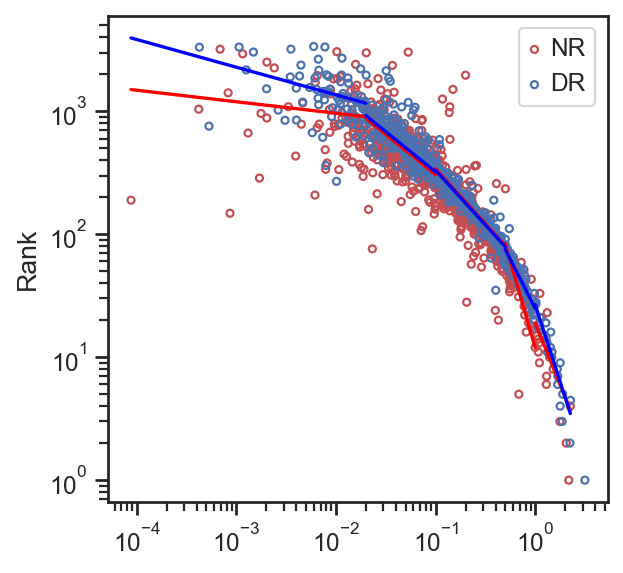

In [51]:
nr_Rank = np.array(pc_gene['NR_predicted_rank_final']+1)
nr_slope_abs = np.array(pc_gene['NR_slope_abs'])

# 拟合参数
nr_0_a = 18.971
nr_0_b = -2.0053
nr_1_a = 11.9660
nr_1_b = -2.8082
nr_2_a = 43.4262
nr_2_b = -0.8941
nr_3_a = 67.3997
nr_3_b = -0.6552
nr_4_a = 626.090
nr_4_b = -0.0935
# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='NR', color='r', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.5, 1, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.1, 0.5, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(0.02, 0.1, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
nr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_4 = power_law(nr_x_fit_4, nr_4_a, nr_4_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'red')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'red')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'red')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'red')
plt.plot(nr_x_fit_4, nr_y_fit_4, 'red')


dr_Rank = np.array(pc_gene['DR_predicted_rank_final']+1)
dr_slope_abs = np.array(pc_gene['DR_slope_abs'])

# 拟合参数

dr_0_a = 26.7224
dr_0_b = -2.5086
dr_1_a = 24.9446
dr_1_b = -1.5951
dr_2_a = 42.6715
dr_2_b = -0.8898
dr_3_a = 70.9957
dr_3_b = -0.6552
dr_4_a = 482.0157
dr_4_b = -0.2250

# 绘制原始数据和拟合曲线
plt.scatter(dr_slope_abs, dr_Rank, label='DR', color='b', s=10, facecolor='none')
dr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
dr_y_fit_0 = power_law(dr_x_fit_0, dr_0_a, dr_0_b)
dr_x_fit_1 = np.linspace(0.5, 1, 100)
dr_y_fit_1 = power_law(dr_x_fit_1, dr_1_a, dr_1_b)
dr_x_fit_2 = np.linspace(0.1, 0.5, 100)
dr_y_fit_2 = power_law(dr_x_fit_2, dr_2_a, dr_2_b)
dr_x_fit_3 = np.linspace(0.02, 0.1, 100)
dr_y_fit_3 = power_law(dr_x_fit_3, dr_3_a, dr_3_b)
dr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
dr_y_fit_4 = power_law(dr_x_fit_4, dr_4_a, dr_4_b)
plt.plot(dr_x_fit_0, dr_y_fit_0, 'blue')
plt.plot(dr_x_fit_1, dr_y_fit_1, 'blue')
plt.plot(dr_x_fit_2, dr_y_fit_2, 'blue')
plt.plot(dr_x_fit_3, dr_y_fit_3, 'blue')
plt.plot(dr_x_fit_4, dr_y_fit_4, 'blue')


plt.ylabel('Rank')
plt.legend()
#plt.ylim(0,3000)
plt.xscale('log')  # 对x轴进行对数缩放
plt.yscale('log')  # 对y轴进行对数缩放

plt.show()

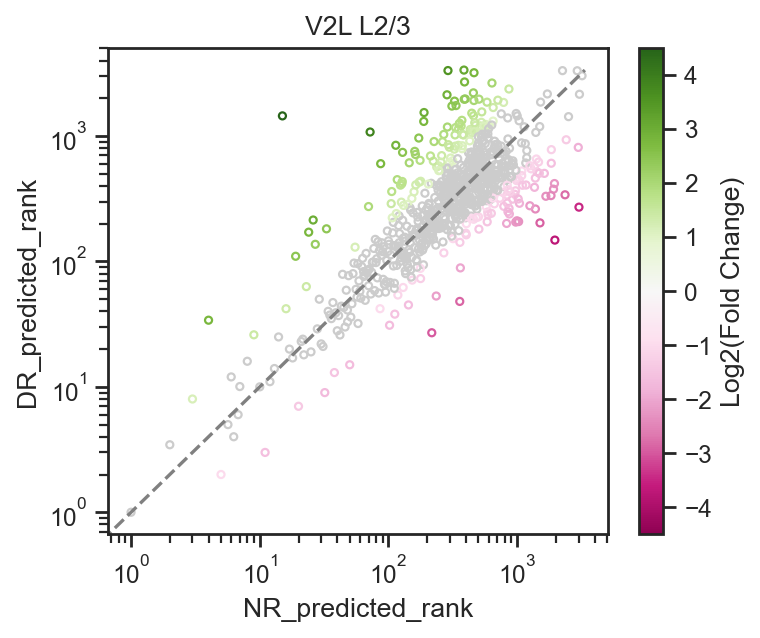

In [20]:
pc_gene['foldchange_predicted'] = (pc_gene['DR_predicted_rank_final']+1)/(pc_gene['NR_predicted_rank_final']+1)
pc_gene['logFC_predicted'] = np.log2(pc_gene['foldchange_predicted'])
# 创建颜色映射条件
color_condition = (pc_gene['logFC_predicted'] > -1) & (pc_gene['logFC_predicted'] < 1)


# 设置 vmin 和 vmax 显式定义颜色范围
vmin, vmax = -4.5, 4.5

# 标准化颜色映射，确保 vmin 和 vmax 生效
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# 初始化所有点的颜色，根据 logFC 值进行颜色映射
colors = plt.cm.PiYG(norm(pc_gene['logFC_predicted']))

# 将 gray_condition 和 color_condition 对应的点设置为灰色
#colors[gray_condition] = [0.5, 0.5, 0.5, 1.0]  # 灰色 (RGBA)
colors[color_condition] = [0.8, 0.8, 0.8, 1.0]  # 浅灰色 (RGBA)

# 创建绘图区域和子图
fig, ax = plt.subplots(figsize=(5,4))

# 绘制散点图，使用自定义颜色
scatter = ax.scatter(x=pc_gene['NR_predicted_rank_final'], y=pc_gene['DR_predicted_rank_final'], 
                     s=10,marker='o', edgecolor=colors, facecolor='none')

# 创建颜色映射对象，仅为非灰色的点设置颜色条
sm = plt.cm.ScalarMappable(cmap="PiYG", norm=norm)
sm.set_array(pc_gene.loc[~color_condition, 'logFC_predicted'])  # 仅使用非灰色数据

# 添加颜色条
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Log2(Fold Change)')

# 添加对角线虚线
limits = [0, max(pc_gene['NR_predicted_rank_final'].max(), pc_gene['DR_predicted_rank_final'].max())]
ax.plot(limits, limits, linestyle='--', color='gray')

# 设置轴标签和标题
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('NR_predicted_rank')
ax.set_ylabel('DR_predicted_rank')
ax.set_title('V2L L2/3')

# 显示图形
plt.show()

In [53]:
# 1. 筛选 logFC > 1 或 logFC < -1 的基因
filtered_df = pc_gene[(pc_gene['logFC_predicted'] > 1) | (pc_gene['logFC_predicted'] < -1)]

In [54]:
filtered_df

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
1            Unc5c          590          248    0.421320 -1.247012 -0.001395   
3             Nfia          178          436    2.441341  1.287674  0.001236   
6    4930599N23Rik         4000          339    0.084979 -3.556754 -0.000216   
8            Tead1          787          275    0.350254 -1.513527  0.000414   
12          Lpgat1          531         4000    7.520677  2.910862  0.000173   
..             ...          ...          ...         ...       ...       ...   
727     St6galnac3          105          289    2.735849  1.451989 -0.003098   
730         Arid1a          246          530    2.149798  1.104201  0.001322   
733          Bach2          115          241    2.086207  1.060882 -0.001826   
738         Frmpd4         1504          203    0.135548 -2.883122 -0.001494   
742          Lrrn1          482          224    0.465839 -1.102098  0.000315   

     NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
1        0.139527 -0.002331      0.233134         252.646941   
3        0.123644  0.000772      0.077192         281.475942   
6        0.021586 -0.000890      0.088986         831.960981   
8        0.041359  0.001126      0.112565         543.355124   
12       0.017272 -0.000054      0.005441         915.052632   
..            ...       ...           ...                ...   
727      0.309791  0.001063      0.106337         123.818993   
730      0.132250  0.000438      0.043786         265.040972   
733      0.182644 -0.001298      0.129781         198.586610   
738      0.149404 -0.002214      0.221377         237.659537   
742      0.031453  0.001346      0.134622         650.107980   

     DR_predicted_rank  NR_predicted_rank_final  DR_predicted_rank_final  \
1           155.896836               590.000000                248.00000   
3           405.211725               178.000000                436.00000   
6           367.869824               831.960981                339.00000   
8           297.984636               787.000000                275.00000   
12         1557.859980               531.000000               1557.85998   
..                 ...                      ...                      ...   
727         313.464338               105.000000                289.00000   
730         595.830662               246.000000                530.00000   
733         262.542161               115.000000                241.00000   
738         163.242773              1504.000000                203.00000   
742         254.123256               482.000000                224.00000   

     foldchange_predicted  logFC_predicted  
1                0.421320        -1.247012  
3                2.441341         1.287674  
6                0.408182        -1.292714  
8                0.350254        -1.513527  
12               2.930188         1.550993  
..                    ...              ...  
727              2.735849         1.451989  
730              2.149798         1.104201  
733              2.086207         1.060882  
738              0.135548        -2.883122  
742              0.465839        -1.102098  

[198 rows x 15 columns]

In [55]:
filtered_df.index = range(0,198)

In [56]:
subclass_deg = pd.read_csv('V2L_L23_subclass_DEG_filter.xls',sep='\t')

In [57]:
subclass_deg

Unnamed: 0      gene  log2FoldChange         pvalue            FDR  \
0               0    Egfem1        0.953603  9.809907e-141  6.904213e-137   
1               1     Epha6        0.951722  1.255475e-130  4.418015e-127   
2               2     Fgf14        0.389464  2.070222e-127  6.244382e-124   
3               3  Cntnap5a        0.798169  2.721281e-123  7.182140e-120   
4               4    Lrrtm4        0.293177  1.383927e-106  2.435019e-103   
...           ...       ...             ...            ...            ...   
21109       21109     Asic2       -0.575658  2.876175e-122  6.747506e-119   
21110       21110    Pde10a       -0.968604  3.285815e-134  1.387534e-130   
21111       21111     Nrxn3       -0.541983  9.550599e-140  5.041284e-136   
21112       21112   Gm42418       -0.539157  1.929556e-146  2.037033e-142   
21113       21113    Malat1       -0.377570   0.000000e+00   0.000000e+00   

       -log10(FDR)     pts_u     pts_d     significance  
0       136.160886  0.925744  0.786772  Not Significant  
1       126.354773  0.917384  0.782146  Not Significant  
2       123.204511  0.998279  0.995143  Not Significant  
3       119.143746  0.938038  0.825624  Not Significant  
4       102.613498  0.999508  0.999075  Not Significant  
...            ...       ...       ...              ...  
21109   118.170857  0.969757  0.985430  Not Significant  
21110   129.857756  0.790017  0.885523  Not Significant  
21111   135.297459  0.994099  0.996531  Not Significant  
21112   141.691002  0.980084  0.989593  Not Significant  
21113          inf  1.000000  1.000000  Not Significant  

[21114 rows x 9 columns]

In [58]:
subclass_deg  = subclass_deg[subclass_deg['FDR'] < 0.05]

In [59]:
subclass_deg

Unnamed: 0      gene  log2FoldChange         pvalue            FDR  \
0               0    Egfem1        0.953603  9.809907e-141  6.904213e-137   
1               1     Epha6        0.951722  1.255475e-130  4.418015e-127   
2               2     Fgf14        0.389464  2.070222e-127  6.244382e-124   
3               3  Cntnap5a        0.798169  2.721281e-123  7.182140e-120   
4               4    Lrrtm4        0.293177  1.383927e-106  2.435019e-103   
...           ...       ...             ...            ...            ...   
21109       21109     Asic2       -0.575658  2.876175e-122  6.747506e-119   
21110       21110    Pde10a       -0.968604  3.285815e-134  1.387534e-130   
21111       21111     Nrxn3       -0.541983  9.550599e-140  5.041284e-136   
21112       21112   Gm42418       -0.539157  1.929556e-146  2.037033e-142   
21113       21113    Malat1       -0.377570   0.000000e+00   0.000000e+00   

       -log10(FDR)     pts_u     pts_d     significance  
0       136.160886  0.925744  0.786772  Not Significant  
1       126.354773  0.917384  0.782146  Not Significant  
2       123.204511  0.998279  0.995143  Not Significant  
3       119.143746  0.938038  0.825624  Not Significant  
4       102.613498  0.999508  0.999075  Not Significant  
...            ...       ...       ...              ...  
21109   118.170857  0.969757  0.985430  Not Significant  
21110   129.857756  0.790017  0.885523  Not Significant  
21111   135.297459  0.994099  0.996531  Not Significant  
21112   141.691002  0.980084  0.989593  Not Significant  
21113          inf  1.000000  1.000000  Not Significant  

[4187 rows x 9 columns]

In [60]:
subclass_deg_df = pd.DataFrame()
subclass_deg_df.index = list(subclass_deg['gene'])
subclass_deg_df['logFC'] = list(subclass_deg['log2FoldChange'])
subclass_deg_dict = subclass_deg_df.to_dict()

deglogFC = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in subclass_deg_dict['logFC'].keys():
        deglogFC.append(subclass_deg_dict['logFC'][pc_gene['Gene'][i]])
    else:
        deglogFC.append(0)
pc_gene['subclassdeglogFC'] = deglogFC

In [76]:
pc_gene

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
0      Nrbp2          291          386    1.325342  0.406365  0.000683   
1      Unc5c          590          248    0.421320 -1.247012 -0.001395   
2     Kif13b          655          496    0.757622 -0.400450 -0.000177   
3       Nfia          178          436    2.441341  1.287674  0.001236   
4    Fam210a          441          620    1.404977  0.490547  0.000678   
..       ...          ...          ...         ...       ...       ...   
740   Tyrobp         2507         1428    0.569777 -0.811531 -0.000020   
741   Zfp608          110          134    1.216216  0.282400  0.002650   
742    Lrrn1          482          224    0.465839 -1.102098  0.000315   
743    Oprm1          241         4000   16.533058  4.047282 -0.000581   
744     Fbn2          435          286    0.658257 -0.603277 -0.000960   

     NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
0        0.068280  0.000523      0.052253         391.226190   
1        0.139527 -0.002331      0.233134         252.646941   
2        0.017745  0.000384      0.038362         912.742584   
3        0.123644  0.000772      0.077192         281.475942   
4        0.067817 -0.000487      0.048660         392.975872   
..            ...       ...           ...                ...   
740      0.002026  0.000085      0.008466        1118.082060   
741      0.264957  0.002920      0.291968         142.393464   
742      0.031453  0.001346      0.134622         650.107980   
743      0.058077 -0.001926      0.192584         434.994147   
744      0.095999 -0.001473      0.147275         312.950286   

     DR_predicted_rank  NR_predicted_rank_final  DR_predicted_rank_final  \
0           528.345085                    291.0               386.000000   
1           155.896836                    590.0               248.000000   
2           651.898857                    655.0               496.000000   
3           405.211725                    178.0               436.000000   
4           554.571983                    441.0               620.000000   
..                 ...                      ...                      ...   
740        1410.385256                   2507.0              1428.000000   
741         127.608040                    110.0               134.000000   
742         254.123256                    482.0               224.000000   
743         184.789973                    241.0               184.789973   
744         234.601801                    435.0               286.000000   

     foldchange_predicted  logFC_predicted  subclassdeglogFC  
0                1.325342         0.406365          0.000000  
1                0.421320        -1.247012          0.000000  
2                0.757622        -0.400450          0.000000  
3                2.441341         1.287674          0.445133  
4                1.404977         0.490547          0.000000  
..                    ...              ...               ...  
740              0.569777        -0.811531          0.000000  
741              1.216216         0.282400          0.217387  
742              0.465839        -1.102098          0.456286  
743              0.767727        -0.381334          0.410333  
744              0.658257        -0.603277          0.486445  

[745 rows x 16 columns]

In [62]:
# 1. 筛选 logFC > 1 或 logFC < -1 的基因
filtered_df = pc_gene[(pc_gene['logFC_predicted'] > 1) | (pc_gene['logFC_predicted'] < -1)]
filtered_df.index = range(0,198)


In [66]:
filtered_df

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
0            Unc5c          590          248    0.421320 -1.247012 -0.001395   
1             Nfia          178          436    2.441341  1.287674  0.001236   
2    4930599N23Rik         4000          339    0.084979 -3.556754 -0.000216   
3            Tead1          787          275    0.350254 -1.513527  0.000414   
4           Lpgat1          531         4000    7.520677  2.910862  0.000173   
..             ...          ...          ...         ...       ...       ...   
193     St6galnac3          105          289    2.735849  1.451989 -0.003098   
194         Arid1a          246          530    2.149798  1.104201  0.001322   
195          Bach2          115          241    2.086207  1.060882 -0.001826   
196         Frmpd4         1504          203    0.135548 -2.883122 -0.001494   
197          Lrrn1          482          224    0.465839 -1.102098  0.000315   

     NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
0        0.139527 -0.002331      0.233134         252.646941   
1        0.123644  0.000772      0.077192         281.475942   
2        0.021586 -0.000890      0.088986         831.960981   
3        0.041359  0.001126      0.112565         543.355124   
4        0.017272 -0.000054      0.005441         915.052632   
..            ...       ...           ...                ...   
193      0.309791  0.001063      0.106337         123.818993   
194      0.132250  0.000438      0.043786         265.040972   
195      0.182644 -0.001298      0.129781         198.586610   
196      0.149404 -0.002214      0.221377         237.659537   
197      0.031453  0.001346      0.134622         650.107980   

     DR_predicted_rank  NR_predicted_rank_final  DR_predicted_rank_final  \
0           155.896836               590.000000                248.00000   
1           405.211725               178.000000                436.00000   
2           367.869824               831.960981                339.00000   
3           297.984636               787.000000                275.00000   
4          1557.859980               531.000000               1557.85998   
..                 ...                      ...                      ...   
193         313.464338               105.000000                289.00000   
194         595.830662               246.000000                530.00000   
195         262.542161               115.000000                241.00000   
196         163.242773              1504.000000                203.00000   
197         254.123256               482.000000                224.00000   

     foldchange_predicted  logFC_predicted  subclassdeglogFC false_positive  
0                0.421320        -1.247012          0.000000             No  
1                2.441341         1.287674          0.445133             No  
2                0.408182        -1.292714          0.688078             No  
3                0.350254        -1.513527          0.414479             No  
4                2.930188         1.550993          0.348299             No  
..                    ...              ...               ...            ...  
193              2.735849         1.451989         -0.236936             No  
194              2.149798         1.104201          0.388152             No  
195              2.086207         1.060882         -0.466184             No  
196              0.135548        -2.883122          0.311837             No  
197              0.465839        -1.102098          0.456286             No  

[198 rows x 17 columns]

In [69]:
fp = []
for i in range(filtered_df.shape[0]):
    test_slope = filtered_df['NR_slope_abs'][i] - filtered_df['DR_slope_abs'][i]
    test_rank = filtered_df['DR_predicted_rank_final'][i] - filtered_df['NR_predicted_rank_final'][i]
    test_slope_raw = filtered_df['NR_slope'][i] * filtered_df['DR_slope'][i]##考虑NR DR是否是相同方向
    a = test_slope*test_rank
    if test_slope_raw < 0:
        fp.append('No')
    elif (filtered_df['subclassdeglogFC'][i] >0.4 or filtered_df['subclassdeglogFC'][i] < - 0.4):
        fp.append('No')
    elif test_slope_raw >= 0:
        if a <0:
            if test_rank < 0:
                if filtered_df['subclassdeglogFC'][i] <= 0:
                    fp.append('Yes')
                else:
                    fp.append('No')
            if test_rank > 0:
                if filtered_df['subclassdeglogFC'][i] >= 0:
                    fp.append('Yes')
                else:
                    fp.append('No')
        else:
            fp.append('No')
filtered_df['false_positive'] = fp

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_36067/3602884899.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['false_positive'] = fp


In [70]:
filtered_df.to_csv('V2L_L23_Lasso_PC1rank_predict_sig.xls',sep='\t')

In [68]:
pc_gene.to_csv('V2L_L23_Lasso_PC1rank.xls',sep='\t')

In [71]:
filtered_df

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
0            Unc5c          590          248    0.421320 -1.247012 -0.001395   
1             Nfia          178          436    2.441341  1.287674  0.001236   
2    4930599N23Rik         4000          339    0.084979 -3.556754 -0.000216   
3            Tead1          787          275    0.350254 -1.513527  0.000414   
4           Lpgat1          531         4000    7.520677  2.910862  0.000173   
..             ...          ...          ...         ...       ...       ...   
193     St6galnac3          105          289    2.735849  1.451989 -0.003098   
194         Arid1a          246          530    2.149798  1.104201  0.001322   
195          Bach2          115          241    2.086207  1.060882 -0.001826   
196         Frmpd4         1504          203    0.135548 -2.883122 -0.001494   
197          Lrrn1          482          224    0.465839 -1.102098  0.000315   

     NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
0        0.139527 -0.002331      0.233134         252.646941   
1        0.123644  0.000772      0.077192         281.475942   
2        0.021586 -0.000890      0.088986         831.960981   
3        0.041359  0.001126      0.112565         543.355124   
4        0.017272 -0.000054      0.005441         915.052632   
..            ...       ...           ...                ...   
193      0.309791  0.001063      0.106337         123.818993   
194      0.132250  0.000438      0.043786         265.040972   
195      0.182644 -0.001298      0.129781         198.586610   
196      0.149404 -0.002214      0.221377         237.659537   
197      0.031453  0.001346      0.134622         650.107980   

     DR_predicted_rank  NR_predicted_rank_final  DR_predicted_rank_final  \
0           155.896836               590.000000                248.00000   
1           405.211725               178.000000                436.00000   
2           367.869824               831.960981                339.00000   
3           297.984636               787.000000                275.00000   
4          1557.859980               531.000000               1557.85998   
..                 ...                      ...                      ...   
193         313.464338               105.000000                289.00000   
194         595.830662               246.000000                530.00000   
195         262.542161               115.000000                241.00000   
196         163.242773              1504.000000                203.00000   
197         254.123256               482.000000                224.00000   

     foldchange_predicted  logFC_predicted  subclassdeglogFC false_positive  
0                0.421320        -1.247012          0.000000             No  
1                2.441341         1.287674          0.445133             No  
2                0.408182        -1.292714          0.688078             No  
3                0.350254        -1.513527          0.414479             No  
4                2.930188         1.550993          0.348299             No  
..                    ...              ...               ...            ...  
193              2.735849         1.451989         -0.236936             No  
194              2.149798         1.104201          0.388152             No  
195              2.086207         1.060882         -0.466184             No  
196              0.135548        -2.883122          0.311837             No  
197              0.465839        -1.102098          0.456286             No  

[198 rows x 17 columns]

In [72]:
filtered_df['false_positive'].value_counts()

false_positive
No     196
Yes      2
Name: count, dtype: int64

In [73]:
filtered_df_1 = filtered_df[filtered_df['false_positive'] == 'No']

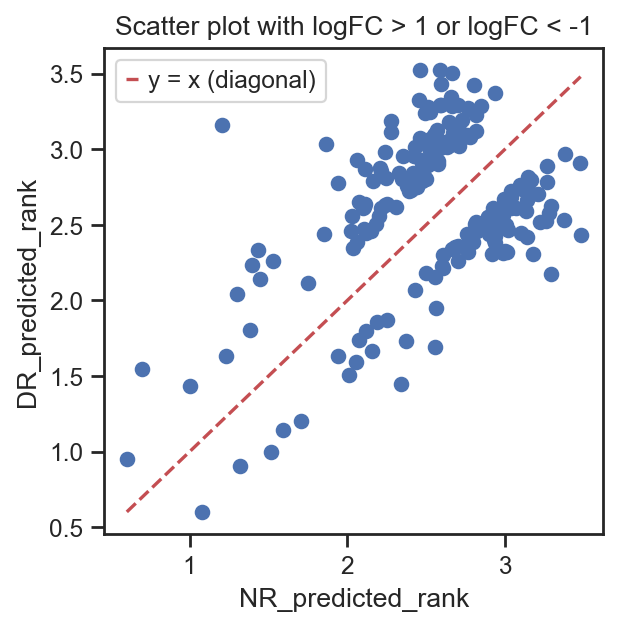

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_36067/3203625981.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_1['log Distance_to_Diagonal'] = log_distances


In [74]:
x = np.log10(filtered_df_1['NR_predicted_rank_final']+1)
y = np.log10(filtered_df_1['DR_predicted_rank_final']+1)

plt.scatter(x, y, color='b')
plt.plot([min(x), max(x)], [min(x), max(x)], 'r--', label='y = x (diagonal)')
plt.xlabel('NR_predicted_rank')
plt.ylabel('DR_predicted_rank')
plt.title('Scatter plot with logFC > 1 or logFC < -1')
plt.legend()
plt.show()

# 3. 计算每个点到对角线的距离
# 计算 y=x 的距离公式： |y - x| / sqrt(2)
log_distances = np.abs(y - x) / np.sqrt(2)

# 打印结果
filtered_df_1['log Distance_to_Diagonal'] = log_distances

In [75]:
variance_of_distances = np.var(log_distances)
variance_of_distances

0.022087096463732733

In [77]:
rcg_gene = list(filtered_df_1['Gene']) 

In [78]:
rcg = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in rcg_gene:
        rcg.append('RCG')
    else:
        rcg.append('Non_RCG')
pc_gene['RCG'] = rcg

In [79]:
pc_gene['RCG'].value_counts()

RCG
Non_RCG    549
RCG        196
Name: count, dtype: int64

In [81]:
len(rcg_gene)

196

In [82]:
non_rcg = pc_gene[pc_gene['RCG'] == 'Non_RCG']
non_rcg_gene = list(non_rcg['Gene'])

RCG = []
for i in range(bin_means_nr_T.shape[0]):
    if bin_means_nr_T.index[i] in rcg_gene:
        RCG.append('RCG')
    elif bin_means_nr_T.index[i] in non_rcg_gene:
        RCG.append('Non_RCG')
    else:
        RCG.append('No')
bin_means_nr_T['RCG'] = RCG
nr_rcg = bin_means_nr_T[bin_means_nr_T['RCG'] == 'RCG']
nr_rcg_sorted = nr_rcg.sort_values(by='slope', ascending=True)
nr_non_rcg = bin_means_nr_T[bin_means_nr_T['RCG'] == 'Non_RCG']
nr_non_rcg_sorted = nr_non_rcg.sort_values(by='slope', ascending=True)

RCG = []
for i in range(bin_means_dr_T.shape[0]):
    if bin_means_dr_T.index[i] in rcg_gene:
        RCG.append('RCG')
    elif bin_means_dr_T.index[i] in non_rcg_gene:
        RCG.append('Non_RCG')
    else:
        RCG.append('No')
bin_means_dr_T['RCG'] = RCG
dr_rcg = bin_means_dr_T[bin_means_dr_T['RCG'] == 'RCG']
dr_non_rcg = bin_means_dr_T[bin_means_dr_T['RCG'] == 'Non_RCG']

rcg_df = pd.DataFrame()
rcg_df.index=list(nr_rcg_sorted.index)
rcg_df['RCG_order']= range(nr_rcg_sorted.shape[0])
rcg_dic = rcg_df.to_dict()

RCG_order = []
for i in range(dr_rcg.shape[0]):
    if dr_rcg.index[i] in rcg_dic['RCG_order'].keys():
        RCG_order.append(rcg_dic['RCG_order'][dr_rcg.index[i]])
dr_rcg['RCG_order'] = RCG_order
dr_rcg_sorted = dr_rcg.sort_values(by='RCG_order', ascending=True)

rcg_df = pd.DataFrame()
rcg_df.index=list(nr_non_rcg_sorted.index)
rcg_df['RCG_order']= range(nr_non_rcg_sorted.shape[0])
rcg_dic = rcg_df.to_dict()

RCG_order = []
for i in range(dr_non_rcg.shape[0]):
    if dr_non_rcg.index[i] in rcg_dic['RCG_order'].keys():
        RCG_order.append(rcg_dic['RCG_order'][dr_non_rcg.index[i]])
    else:
        RCG_order.append('No')
dr_non_rcg['RCG_order'] = RCG_order
dr_non_rcg = dr_non_rcg[dr_non_rcg['RCG_order'] != 'No']
dr_non_rcg_sorted = dr_non_rcg.sort_values(by='RCG_order', ascending=True)

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_36067/4190480033.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_rcg['RCG_order'] = RCG_order
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_36067/4190480033.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_non_rcg['RCG_order'] = RCG_order


In [83]:
nr_non_rcg_sorted

0         1         2         3         4         5         6  \
Etl4     2.517990  2.299227  2.205330  2.255126  2.344445  2.162281  2.304191   
Kcnq5    3.397494  3.452586  3.465416  3.503183  3.296808  3.314879  3.375728   
Slc24a2  1.901281  1.947827  2.252198  1.819324  1.773333  2.368797  2.072129   
Pde7b    1.521405  1.692135  1.887266  1.586971  1.639854  1.834156  1.647328   
Frmd5    1.965051  1.711677  2.215325  2.197862  2.240985  1.808838  2.257834   
...           ...       ...       ...       ...       ...       ...       ...   
Ptprk    0.460745  0.530988  0.549924  0.645009  0.614160  0.712746  0.869050   
Epha6    1.276098  1.207394  0.705626  1.033755  1.022579  1.237935  1.033614   
Robo1    0.413084  0.375578  0.445773  0.397809  0.612746  0.577269  0.601037   
Cntn5    0.628466  0.857261  0.659913  0.599530  0.563225  0.844582  0.498736   
Cdh13    0.029492  0.000000  0.035521  0.098364  0.127522  0.100580  0.069570   

                7         8         9  ...        92        93        94  \
Etl4     2.119729  2.242942  2.248152  ...  0.518464  0.652855  0.444727   
Kcnq5    3.246964  3.365779  3.132836  ...  2.006816  1.793047  1.848295   
Slc24a2  2.083551  2.256603  2.193380  ...  0.959136  1.024886  1.122686   
Pde7b    1.487594  1.431384  1.609138  ...  0.984028  0.562863  0.792266   
Frmd5    1.963358  2.088239  2.084097  ...  1.309152  0.843905  0.967699   
...           ...       ...       ...  ...       ...       ...       ...   
Ptprk    0.622077  0.765720  0.826948  ...  2.033921  2.181611  1.935141   
Epha6    1.112007  1.011225  1.114227  ...  2.689827  2.773299  2.833688   
Robo1    0.725948  0.422285  0.755163  ...  2.270482  2.310364  2.430565   
Cntn5    0.565863  0.654924  0.588386  ...  2.370531  2.369254  2.560750   
Cdh13    0.140346  0.095683  0.070399  ...  2.256415  2.347733  2.417377   

               95        96        97        98        99     slope      RCG  
Etl4     0.576667  0.468969  0.434908  0.457387  0.313370 -0.018278  Non_RCG  
Kcnq5    1.688515  1.533186  1.778084  1.749033  1.799781 -0.016695  Non_RCG  
Slc24a2  0.885818  0.939754  0.752107  0.876851  1.007609 -0.013008  Non_RCG  
Pde7b    0.636477  0.356111  0.223758  0.420791  0.262271 -0.011036  Non_RCG  
Frmd5    1.066733  1.171962  0.846632  0.567791  0.467771 -0.010661  Non_RCG  
...           ...       ...       ...       ...       ...       ...      ...  
Ptprk    2.018129  1.963068  2.046136  1.953926  2.115772  0.015123  Non_RCG  
Epha6    2.353202  2.336947  2.739824  2.835411  2.957677  0.017361  Non_RCG  
Robo1    2.379824  2.336859  2.267789  2.452467  2.414340  0.017711  Non_RCG  
Cntn5    2.654647  2.702972  2.880572  3.119560  3.211836  0.020507  Non_RCG  
Cdh13    2.364392  2.707495  2.814227  2.953641  2.916942  0.021733  Non_RCG  

[549 rows x 102 columns]

In [84]:
dr_non_rcg_sorted

0         1         2         3         4         5         6  \
Etl4     2.115137  2.103494  2.110424  1.993048  1.937839  1.945459  1.783508   
Kcnq5    3.542943  3.290349  3.546162  3.463737  3.543710  3.298250  3.409257   
Slc24a2  1.573621  1.828670  1.689502  1.858365  1.926095  2.029133  2.001090   
Pde7b    1.176409  1.231023  1.342826  1.528474  1.361080  1.700651  1.565979   
Frmd5    2.189217  2.016130  2.060574  1.930583  2.104681  2.117252  2.044341   
...           ...       ...       ...       ...       ...       ...       ...   
Ptprk    0.560889  0.709093  0.997484  0.733849  0.835986  0.892066  0.854385   
Epha6    1.421921  1.512015  1.584620  1.368543  1.526958  1.461543  1.683408   
Robo1    0.630984  0.550389  0.646220  0.583987  0.577618  0.407326  0.719535   
Cntn5    0.769493  0.622527  0.536822  0.543495  0.578240  0.533377  1.062186   
Cdh13    0.036247  0.062524  0.032328  0.170060  0.086719  0.125293  0.158055   

                7         8         9  ...        93        94        95  \
Etl4     1.812982  1.488119  1.782153  ...  0.391552  0.675300  0.530864   
Kcnq5    3.461069  3.310612  3.429636  ...  1.962681  1.943707  1.895740   
Slc24a2  1.929405  2.008468  1.840100  ...  1.001470  0.650827  0.791570   
Pde7b    1.622607  1.380494  1.847066  ...  0.621079  0.635421  0.539619   
Frmd5    1.921684  2.048606  1.952219  ...  0.995711  0.994376  0.683710   
...           ...       ...       ...  ...       ...       ...       ...   
Ptprk    0.996296  1.024594  0.915942  ...  2.229409  2.396401  2.334343   
Epha6    1.538307  1.706901  1.691793  ...  3.110966  3.247563  3.061861   
Robo1    0.608721  0.631508  0.574967  ...  2.649172  2.591370  2.649226   
Cntn5    0.618892  0.766452  0.872228  ...  2.772642  2.943602  2.911921   
Cdh13    0.201965  0.182922  0.100212  ...  2.793692  2.804129  2.998412   

               96        97        98        99     slope      RCG  RCG_order  
Etl4     0.312924  0.526155  0.426959  0.383252 -0.016798  Non_RCG          0  
Kcnq5    2.000877  1.898140  1.915047  1.983107 -0.016862  Non_RCG          1  
Slc24a2  1.034016  0.929006  0.779571  0.805364 -0.013168  Non_RCG          2  
Pde7b    0.398103  0.521674  0.539774  0.604997 -0.010814  Non_RCG          3  
Frmd5    0.612658  0.522841  0.538710  0.579033 -0.012477  Non_RCG          4  
...           ...       ...       ...       ...       ...      ...        ...  
Ptprk    2.319475  2.454750  2.328483  2.467885  0.014763  Non_RCG        544  
Epha6    3.298456  3.179400  3.293236  3.301910  0.018892  Non_RCG        545  
Robo1    2.737121  2.819337  2.802889  2.763664  0.022607  Non_RCG        546  
Cntn5    3.219584  3.063876  3.288716  3.400187  0.022337  Non_RCG        547  
Cdh13    3.068296  3.129681  3.070669  3.211873  0.031535  Non_RCG        548  

[549 rows x 103 columns]

In [85]:
nr_rcg_sorted

0         1         2         3         4         5  \
Hs6st3    3.578342  3.379573  3.490191  3.250511  3.284392  3.125900   
Cntnap2   3.515059  3.316636  3.107047  3.155781  3.004039  2.921926   
Unc5d     2.976042  3.093550  2.824728  3.001395  2.825282  2.827452   
Brinp3    2.089909  1.520473  1.742116  1.233706  1.777714  1.776037   
Kcnh5     1.445313  1.385048  1.237819  0.944813  1.012720  0.927245   
...            ...       ...       ...       ...       ...       ...   
Egfem1    2.491886  2.415109  2.187387  2.113825  1.871074  2.019739   
Cntnap5a  1.601186  1.259390  1.650473  1.899347  1.533036  1.638558   
Dpyd      0.031540  0.032406  0.024966  0.000000  0.102197  0.024313   
Gpc6      0.844936  0.966586  1.297168  0.876303  1.328639  1.632814   
Kirrel3   0.478805  0.796086  0.757737  0.599932  0.878158  0.703468   

                 6         7         8         9  ...        92        93  \
Hs6st3    3.231078  3.271540  3.306256  3.115592  ...  2.328950  2.225600   
Cntnap2   2.842646  2.760105  2.767750  2.609029  ...  2.006862  1.851417   
Unc5d     2.818488  2.949113  2.767466  2.975153  ...  1.950305  1.803041   
Brinp3    1.731408  1.450481  1.454794  1.611859  ...  0.619543  0.772264   
Kcnh5     0.967685  0.866239  0.903850  0.679280  ...  0.280274  0.333033   
...            ...       ...       ...       ...  ...       ...       ...   
Egfem1    1.509795  1.823144  1.621716  1.543517  ...  2.429604  2.582987   
Cntnap5a  1.387400  1.306776  1.464899  1.462636  ...  2.172587  2.297177   
Dpyd      0.040830  0.000000  0.032623  0.136948  ...  1.026868  0.935000   
Gpc6      1.907603  1.505649  1.498258  1.304185  ...  2.906564  2.764268   
Kirrel3   0.735663  0.782388  1.089465  0.986481  ...  3.047859  3.001505   

                94        95        96        97        98        99  \
Hs6st3    2.312739  2.171148  1.835106  1.715697  1.779552  1.594912   
Cntnap2   1.961305  1.751763  1.677392  1.666018  1.629365  1.682401   
Unc5d     1.911618  2.108091  2.192887  2.066850  2.054297  1.805200   
Brinp3    0.797649  0.525000  0.645254  0.587842  0.587763  0.722448   
Kcnh5     0.381715  0.128139  0.262197  0.106986  0.096990  0.019973   
...            ...       ...       ...       ...       ...       ...   
Egfem1    2.406946  2.345726  2.036908  2.172575  1.545547  1.953527   
Cntnap5a  2.178222  2.117385  1.974019  1.901872  1.886338  1.986837   
Dpyd      1.173620  1.519020  1.857849  2.073670  1.658475  2.484931   
Gpc6      2.799134  2.697423  2.427032  2.352791  1.829710  2.056628   
Kirrel3   2.958008  2.846960  2.951581  2.613309  2.629333  2.789928   

             slope  RCG  
Hs6st3   -0.011596  RCG  
Cntnap2  -0.011143  RCG  
Unc5d    -0.010041  RCG  
Brinp3   -0.007941  RCG  
Kcnh5    -0.007721  RCG  
...            ...  ...  
Egfem1    0.008126  RCG  
Cntnap5a  0.009639  RCG  
Dpyd      0.009989  RCG  
Gpc6      0.013961  RCG  
Kirrel3   0.022543  RCG  

[196 rows x 102 columns]

In [86]:
dr_rcg_sorted

0         1         2         3         4         5  \
Hs6st3    3.411033  3.581137  3.526057  3.499050  3.354170  3.448829   
Cntnap2   3.776868  3.745732  3.502887  3.507192  3.415228  3.388668   
Unc5d     2.933089  2.906950  2.577697  2.823147  2.929016  2.735265   
Brinp3    1.782938  1.552847  1.599064  1.361801  1.167869  1.085610   
Kcnh5     1.686213  1.759681  1.932920  1.775344  1.718423  1.585873   
...            ...       ...       ...       ...       ...       ...   
Egfem1    2.819438  2.986993  2.718826  2.706440  2.801107  2.649477   
Cntnap5a  1.938965  2.092318  2.308779  2.294137  2.309580  2.537251   
Dpyd      0.000000  0.000000  0.183467  0.085103  0.052985  0.078649   
Gpc6      0.646047  0.933453  1.610100  1.620654  1.718357  1.638418   
Kirrel3   0.534344  0.751711  0.749835  0.900570  0.940040  1.043009   

                 6         7         8         9  ...        93        94  \
Hs6st3    3.257808  3.375144  3.196559  3.382571  ...  2.010528  1.744921   
Cntnap2   3.503415  3.227378  3.152980  3.376352  ...  1.977612  1.789009   
Unc5d     2.854607  2.890719  2.886189  2.495379  ...  2.237747  2.089547   
Brinp3    0.803487  1.134768  1.006881  0.917008  ...  0.565910  1.034747   
Kcnh5     1.588081  1.623819  1.495589  1.436884  ...  0.135871  0.065740   
...            ...       ...       ...       ...  ...       ...       ...   
Egfem1    2.740681  2.665201  2.238890  2.567551  ...  2.568353  2.066648   
Cntnap5a  2.085572  2.482982  2.308829  2.366312  ...  2.539249  2.402021   
Dpyd      0.070960  0.070304  0.034949  0.067137  ...  2.089808  1.975195   
Gpc6      1.699894  1.842310  1.952405  1.987784  ...  2.725186  2.631684   
Kirrel3   1.040957  1.340198  1.070895  1.150935  ...  2.799618  2.707738   

                95        96        97        98        99     slope  RCG  \
Hs6st3    1.752522  1.836815  1.499616  1.544760  1.311010 -0.016668  RCG   
Cntnap2   1.721557  1.889732  1.661270  1.820623  1.767952 -0.014691  RCG   
Unc5d     2.223180  2.000194  2.068437  2.235630  2.182401 -0.007216  RCG   
Brinp3    0.634562  0.554508  0.858062  0.915942  0.834196 -0.001828  RCG   
Kcnh5     0.149770  0.268698  0.113816  0.000000  0.154804 -0.014330  RCG   
...            ...       ...       ...       ...       ...       ...  ...   
Egfem1    2.294097  2.306181  1.992079  2.037706  2.089329 -0.000075  RCG   
Cntnap5a  2.110596  2.268636  2.043223  2.003036  1.607204  0.002099  RCG   
Dpyd      2.175089  2.309929  2.324573  2.472199  2.485910  0.017801  RCG   
Gpc6      2.503868  2.248927  1.963562  1.669773  1.987891  0.010168  RCG   
Kirrel3   2.642013  2.622051  2.529792  2.610222  2.548916  0.017823  RCG   

          RCG_order  
Hs6st3            0  
Cntnap2           1  
Unc5d             2  
Brinp3            3  
Kcnh5             4  
...             ...  
Egfem1          191  
Cntnap5a        192  
Dpyd            193  
Gpc6            194  
Kirrel3         195  

[196 rows x 103 columns]

(-0.45, 0.45)

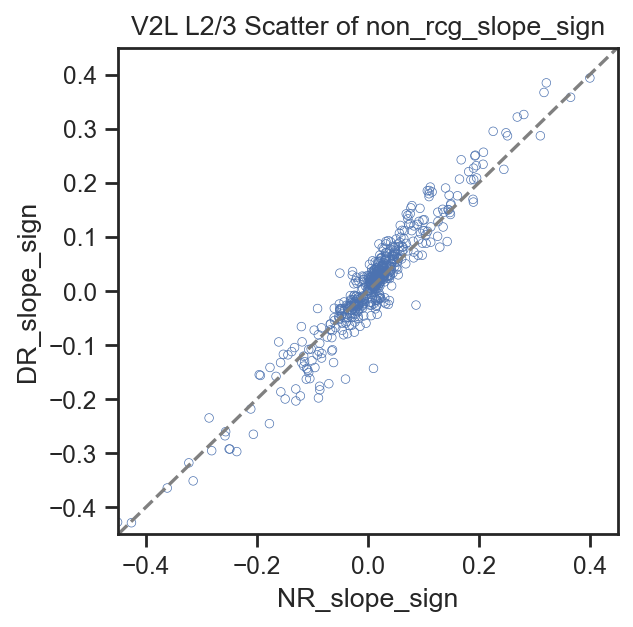

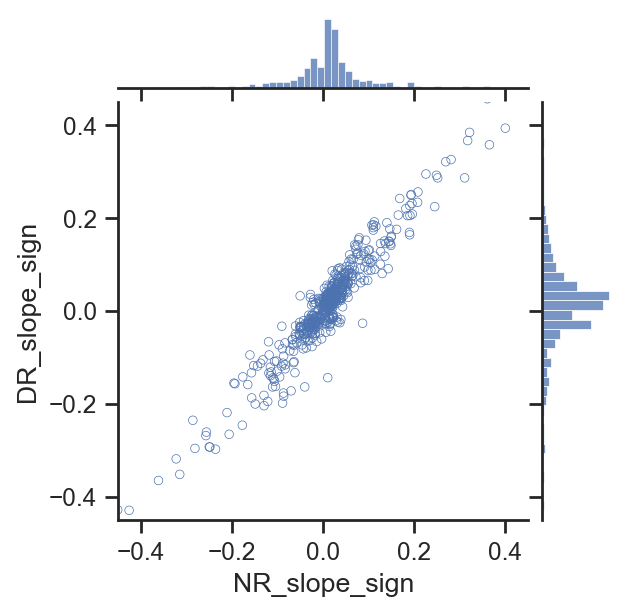

In [87]:
nr_dr_non_rcg_slope = pd.DataFrame()
nr_dr_non_rcg_slope.index = list(nr_non_rcg_sorted.index)
nr_dr_non_rcg_slope['NR_slope'] = list(nr_non_rcg_sorted['slope'])
nr_dr_non_rcg_slope['DR_slope'] = list(dr_non_rcg_sorted['slope'])

nr_dr_non_rcg_slope['NR_slope*100'] = nr_non_rcg_sorted['slope']*100
nr_dr_non_rcg_slope['DR_slope*100'] = dr_non_rcg_sorted['slope']*100

nr_dr_non_rcg_slope['NR_slope_sign'] = np.log10(nr_dr_non_rcg_slope['NR_slope*100'].abs()+1)*np.sign(nr_dr_non_rcg_slope['NR_slope*100'])
nr_dr_non_rcg_slope['DR_slope_sign'] = np.log10(nr_dr_non_rcg_slope['DR_slope*100'].abs()+1)*np.sign(nr_dr_non_rcg_slope['DR_slope*100'])

# 创建绘图区域和子图
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(data=nr_dr_non_rcg_slope, x='NR_slope_sign', y='DR_slope_sign',s=15, marker='o', edgecolor='b', facecolor='none')
plt.title('V2L L2/3 Scatter of non_rcg_slope_sign')
plt.xlim(-0.45,0.45)
plt.ylim(-0.45,0.45)
# 添加对角线虚线
limits = [-0.45, 0.45]
ax.plot(limits, limits, linestyle='--', color='gray')
plt.savefig('V2L_L23_Scatter_of_non_rcg_slope_sign.pdf')

sns.jointplot(data=nr_dr_non_rcg_slope, x='NR_slope_sign', y='DR_slope_sign',s=15, marker='o', edgecolor='b', facecolor='none',height=4)
plt.xlim(-0.45,0.45)
plt.ylim(-0.45,0.45)

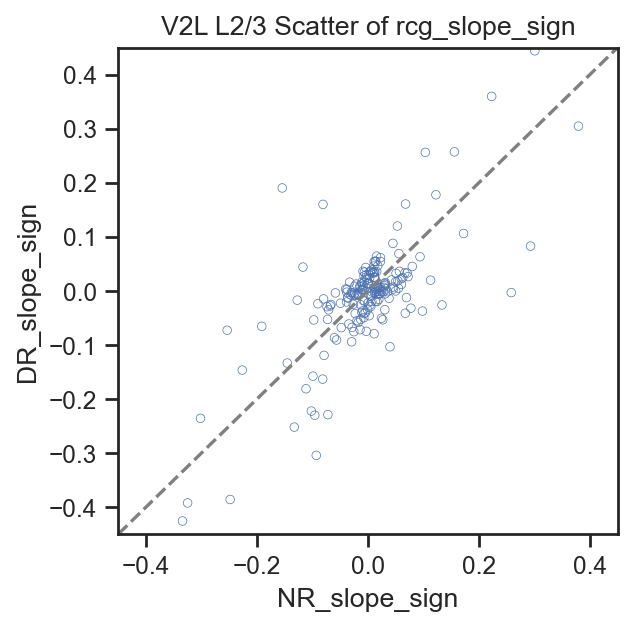

In [90]:
nr_dr_rcg_slope = pd.DataFrame()
nr_dr_rcg_slope.index = list(nr_rcg_sorted.index)
nr_dr_rcg_slope['NR_slope'] = list(nr_rcg_sorted['slope'])
nr_dr_rcg_slope['DR_slope'] = list(dr_rcg_sorted['slope'])

nr_dr_rcg_slope['NR_slope*100'] = nr_dr_rcg_slope['NR_slope']*100
nr_dr_rcg_slope['DR_slope*100'] = nr_dr_rcg_slope['DR_slope']*100

nr_dr_rcg_slope['NR_slope_sign'] = np.log10(nr_dr_rcg_slope['NR_slope*100'].abs()+1)*np.sign(nr_dr_rcg_slope['NR_slope*100'])
nr_dr_rcg_slope['DR_slope_sign'] = np.log10(nr_dr_rcg_slope['DR_slope*100'].abs()+1)*np.sign(nr_dr_rcg_slope['DR_slope*100'])

# 创建绘图区域和子图
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(data=nr_dr_rcg_slope, x='NR_slope_sign', y='DR_slope_sign',s=15, marker='o', edgecolor='b', facecolor='none')
plt.title('V2L L2/3 Scatter of rcg_slope_sign')
plt.xlim(-0.45,0.45)
plt.ylim(-0.45,0.45)
# 添加对角线虚线
limits = [-0.45, 0.45]
ax.plot(limits, limits, linestyle='--', color='gray')
plt.savefig('V2L_L23_Scatter_of_rcg_slope_sign.pdf')

(-0.45, 0.45)

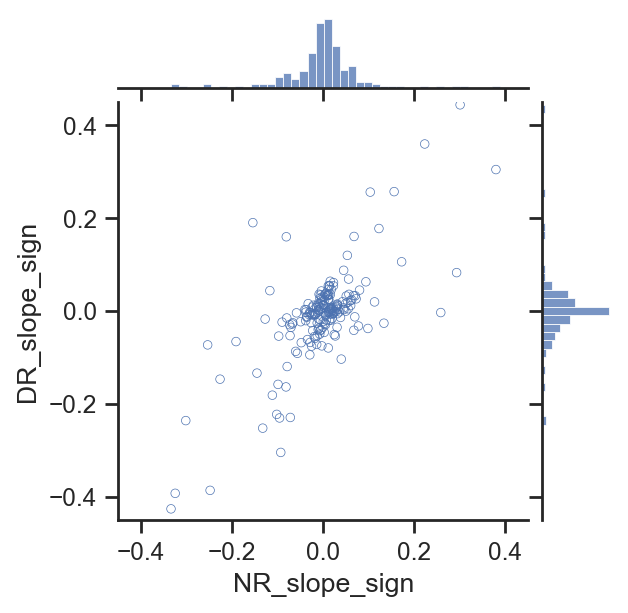

In [91]:
sns.jointplot(data=nr_dr_rcg_slope, x='NR_slope_sign', y='DR_slope_sign',s=15, marker='o', edgecolor='b', facecolor='none',height=4)
plt.xlim(-0.45,0.45)
plt.ylim(-0.45,0.45)

In [92]:
nr_non_rcg_sorted

0         1         2         3         4         5         6  \
Etl4     2.517990  2.299227  2.205330  2.255126  2.344445  2.162281  2.304191   
Kcnq5    3.397494  3.452586  3.465416  3.503183  3.296808  3.314879  3.375728   
Slc24a2  1.901281  1.947827  2.252198  1.819324  1.773333  2.368797  2.072129   
Pde7b    1.521405  1.692135  1.887266  1.586971  1.639854  1.834156  1.647328   
Frmd5    1.965051  1.711677  2.215325  2.197862  2.240985  1.808838  2.257834   
...           ...       ...       ...       ...       ...       ...       ...   
Ptprk    0.460745  0.530988  0.549924  0.645009  0.614160  0.712746  0.869050   
Epha6    1.276098  1.207394  0.705626  1.033755  1.022579  1.237935  1.033614   
Robo1    0.413084  0.375578  0.445773  0.397809  0.612746  0.577269  0.601037   
Cntn5    0.628466  0.857261  0.659913  0.599530  0.563225  0.844582  0.498736   
Cdh13    0.029492  0.000000  0.035521  0.098364  0.127522  0.100580  0.069570   

                7         8         9  ...        92        93        94  \
Etl4     2.119729  2.242942  2.248152  ...  0.518464  0.652855  0.444727   
Kcnq5    3.246964  3.365779  3.132836  ...  2.006816  1.793047  1.848295   
Slc24a2  2.083551  2.256603  2.193380  ...  0.959136  1.024886  1.122686   
Pde7b    1.487594  1.431384  1.609138  ...  0.984028  0.562863  0.792266   
Frmd5    1.963358  2.088239  2.084097  ...  1.309152  0.843905  0.967699   
...           ...       ...       ...  ...       ...       ...       ...   
Ptprk    0.622077  0.765720  0.826948  ...  2.033921  2.181611  1.935141   
Epha6    1.112007  1.011225  1.114227  ...  2.689827  2.773299  2.833688   
Robo1    0.725948  0.422285  0.755163  ...  2.270482  2.310364  2.430565   
Cntn5    0.565863  0.654924  0.588386  ...  2.370531  2.369254  2.560750   
Cdh13    0.140346  0.095683  0.070399  ...  2.256415  2.347733  2.417377   

               95        96        97        98        99     slope      RCG  
Etl4     0.576667  0.468969  0.434908  0.457387  0.313370 -0.018278  Non_RCG  
Kcnq5    1.688515  1.533186  1.778084  1.749033  1.799781 -0.016695  Non_RCG  
Slc24a2  0.885818  0.939754  0.752107  0.876851  1.007609 -0.013008  Non_RCG  
Pde7b    0.636477  0.356111  0.223758  0.420791  0.262271 -0.011036  Non_RCG  
Frmd5    1.066733  1.171962  0.846632  0.567791  0.467771 -0.010661  Non_RCG  
...           ...       ...       ...       ...       ...       ...      ...  
Ptprk    2.018129  1.963068  2.046136  1.953926  2.115772  0.015123  Non_RCG  
Epha6    2.353202  2.336947  2.739824  2.835411  2.957677  0.017361  Non_RCG  
Robo1    2.379824  2.336859  2.267789  2.452467  2.414340  0.017711  Non_RCG  
Cntn5    2.654647  2.702972  2.880572  3.119560  3.211836  0.020507  Non_RCG  
Cdh13    2.364392  2.707495  2.814227  2.953641  2.916942  0.021733  Non_RCG  

[549 rows x 102 columns]

In [93]:
dr_non_rcg_sorted

0         1         2         3         4         5         6  \
Etl4     2.115137  2.103494  2.110424  1.993048  1.937839  1.945459  1.783508   
Kcnq5    3.542943  3.290349  3.546162  3.463737  3.543710  3.298250  3.409257   
Slc24a2  1.573621  1.828670  1.689502  1.858365  1.926095  2.029133  2.001090   
Pde7b    1.176409  1.231023  1.342826  1.528474  1.361080  1.700651  1.565979   
Frmd5    2.189217  2.016130  2.060574  1.930583  2.104681  2.117252  2.044341   
...           ...       ...       ...       ...       ...       ...       ...   
Ptprk    0.560889  0.709093  0.997484  0.733849  0.835986  0.892066  0.854385   
Epha6    1.421921  1.512015  1.584620  1.368543  1.526958  1.461543  1.683408   
Robo1    0.630984  0.550389  0.646220  0.583987  0.577618  0.407326  0.719535   
Cntn5    0.769493  0.622527  0.536822  0.543495  0.578240  0.533377  1.062186   
Cdh13    0.036247  0.062524  0.032328  0.170060  0.086719  0.125293  0.158055   

                7         8         9  ...        93        94        95  \
Etl4     1.812982  1.488119  1.782153  ...  0.391552  0.675300  0.530864   
Kcnq5    3.461069  3.310612  3.429636  ...  1.962681  1.943707  1.895740   
Slc24a2  1.929405  2.008468  1.840100  ...  1.001470  0.650827  0.791570   
Pde7b    1.622607  1.380494  1.847066  ...  0.621079  0.635421  0.539619   
Frmd5    1.921684  2.048606  1.952219  ...  0.995711  0.994376  0.683710   
...           ...       ...       ...  ...       ...       ...       ...   
Ptprk    0.996296  1.024594  0.915942  ...  2.229409  2.396401  2.334343   
Epha6    1.538307  1.706901  1.691793  ...  3.110966  3.247563  3.061861   
Robo1    0.608721  0.631508  0.574967  ...  2.649172  2.591370  2.649226   
Cntn5    0.618892  0.766452  0.872228  ...  2.772642  2.943602  2.911921   
Cdh13    0.201965  0.182922  0.100212  ...  2.793692  2.804129  2.998412   

               96        97        98        99     slope      RCG  RCG_order  
Etl4     0.312924  0.526155  0.426959  0.383252 -0.016798  Non_RCG          0  
Kcnq5    2.000877  1.898140  1.915047  1.983107 -0.016862  Non_RCG          1  
Slc24a2  1.034016  0.929006  0.779571  0.805364 -0.013168  Non_RCG          2  
Pde7b    0.398103  0.521674  0.539774  0.604997 -0.010814  Non_RCG          3  
Frmd5    0.612658  0.522841  0.538710  0.579033 -0.012477  Non_RCG          4  
...           ...       ...       ...       ...       ...      ...        ...  
Ptprk    2.319475  2.454750  2.328483  2.467885  0.014763  Non_RCG        544  
Epha6    3.298456  3.179400  3.293236  3.301910  0.018892  Non_RCG        545  
Robo1    2.737121  2.819337  2.802889  2.763664  0.022607  Non_RCG        546  
Cntn5    3.219584  3.063876  3.288716  3.400187  0.022337  Non_RCG        547  
Cdh13    3.068296  3.129681  3.070669  3.211873  0.031535  Non_RCG        548  

[549 rows x 103 columns]

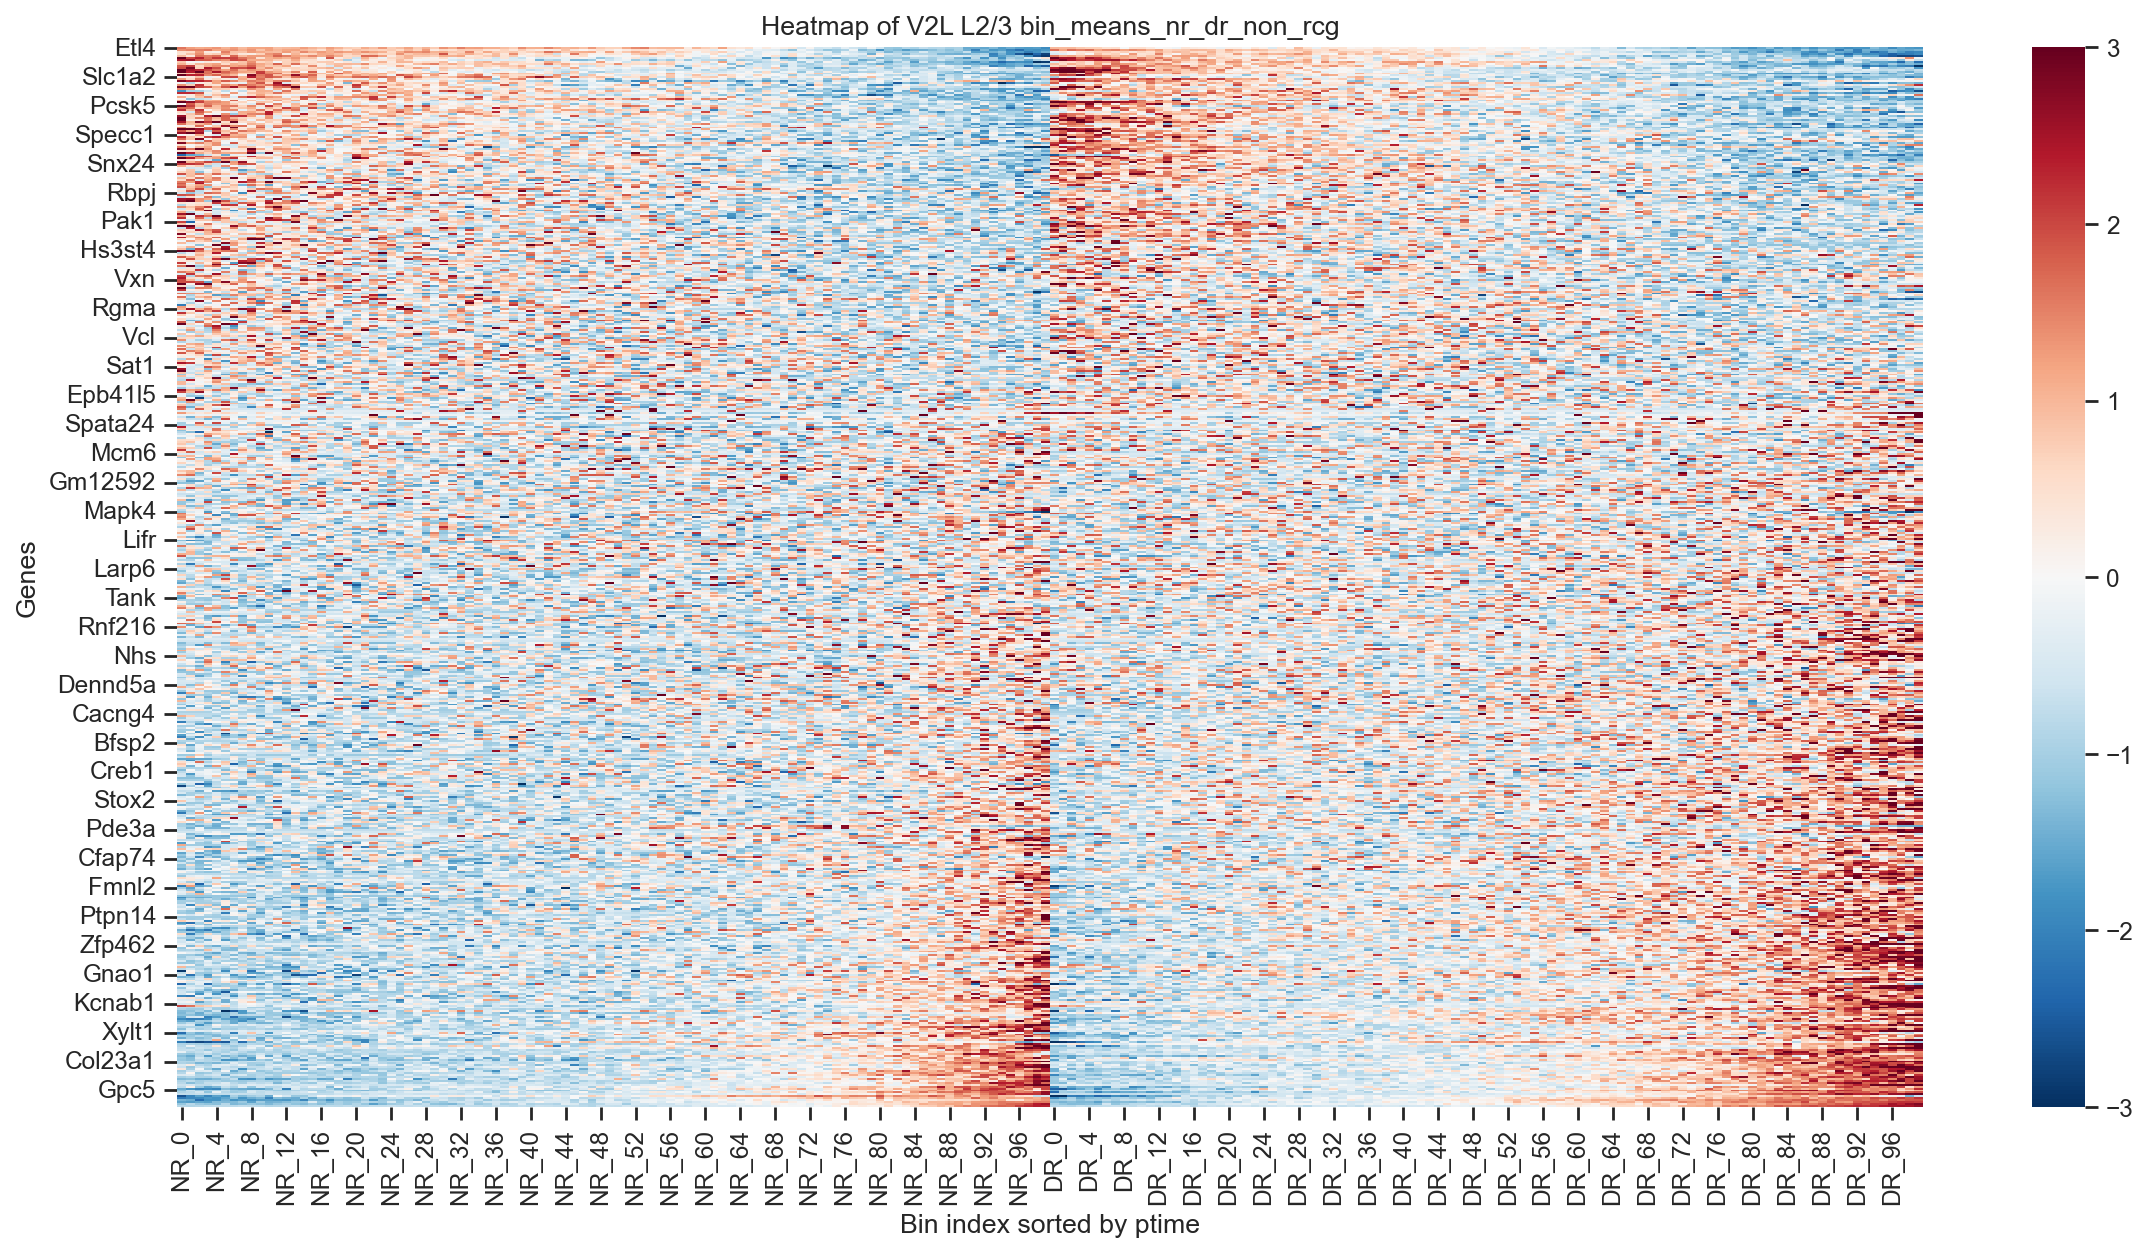

In [94]:
from scipy.stats import zscore
nr_non_rcg_sorted_slope = nr_non_rcg_sorted
dr_non_rcg_sorted_slope = dr_non_rcg_sorted
del nr_non_rcg_sorted_slope['slope']
del nr_non_rcg_sorted_slope['RCG']
del dr_non_rcg_sorted_slope['slope']
del dr_non_rcg_sorted_slope['RCG']
del dr_non_rcg_sorted_slope['RCG_order']
# 为df1和df2生成新的列名映射
columns_mapping1 = {i: 'NR_' + str(i) for i in range(100)}
columns_mapping2 = {i: 'DR_' + str(i) for i in range(100)}

# 使用rename方法重命名列
nr_non_rcg_sorted_slope = nr_non_rcg_sorted_slope.rename(columns=columns_mapping1)
dr_non_rcg_sorted_slope = dr_non_rcg_sorted_slope.rename(columns=columns_mapping2)

merged_nr_dr_non_rcg_df = nr_non_rcg_sorted_slope.join(dr_non_rcg_sorted_slope)
merged_nr_dr_non_rcg_df_zscore = merged_nr_dr_non_rcg_df.apply(zscore, axis=1)

# 使用 seaborn 绘制热图
plt.figure(figsize=(15,8))
sns.heatmap(merged_nr_dr_non_rcg_df_zscore, cmap='RdBu_r', fmt='.2f',vmin=-3,vmax=3)
plt.title('Heatmap of V2L L2/3 bin_means_nr_dr_non_rcg')
plt.xlabel('Bin index sorted by ptime')
plt.ylabel('Genes')
plt.tight_layout()
# 显示图表
#plt.xticks(rotation=45, ha='right')  # 旋转X轴标签使其不重叠

# 显示热图
plt.savefig('Heatmap_of_V2L_L23_Non_RCG.pdf')

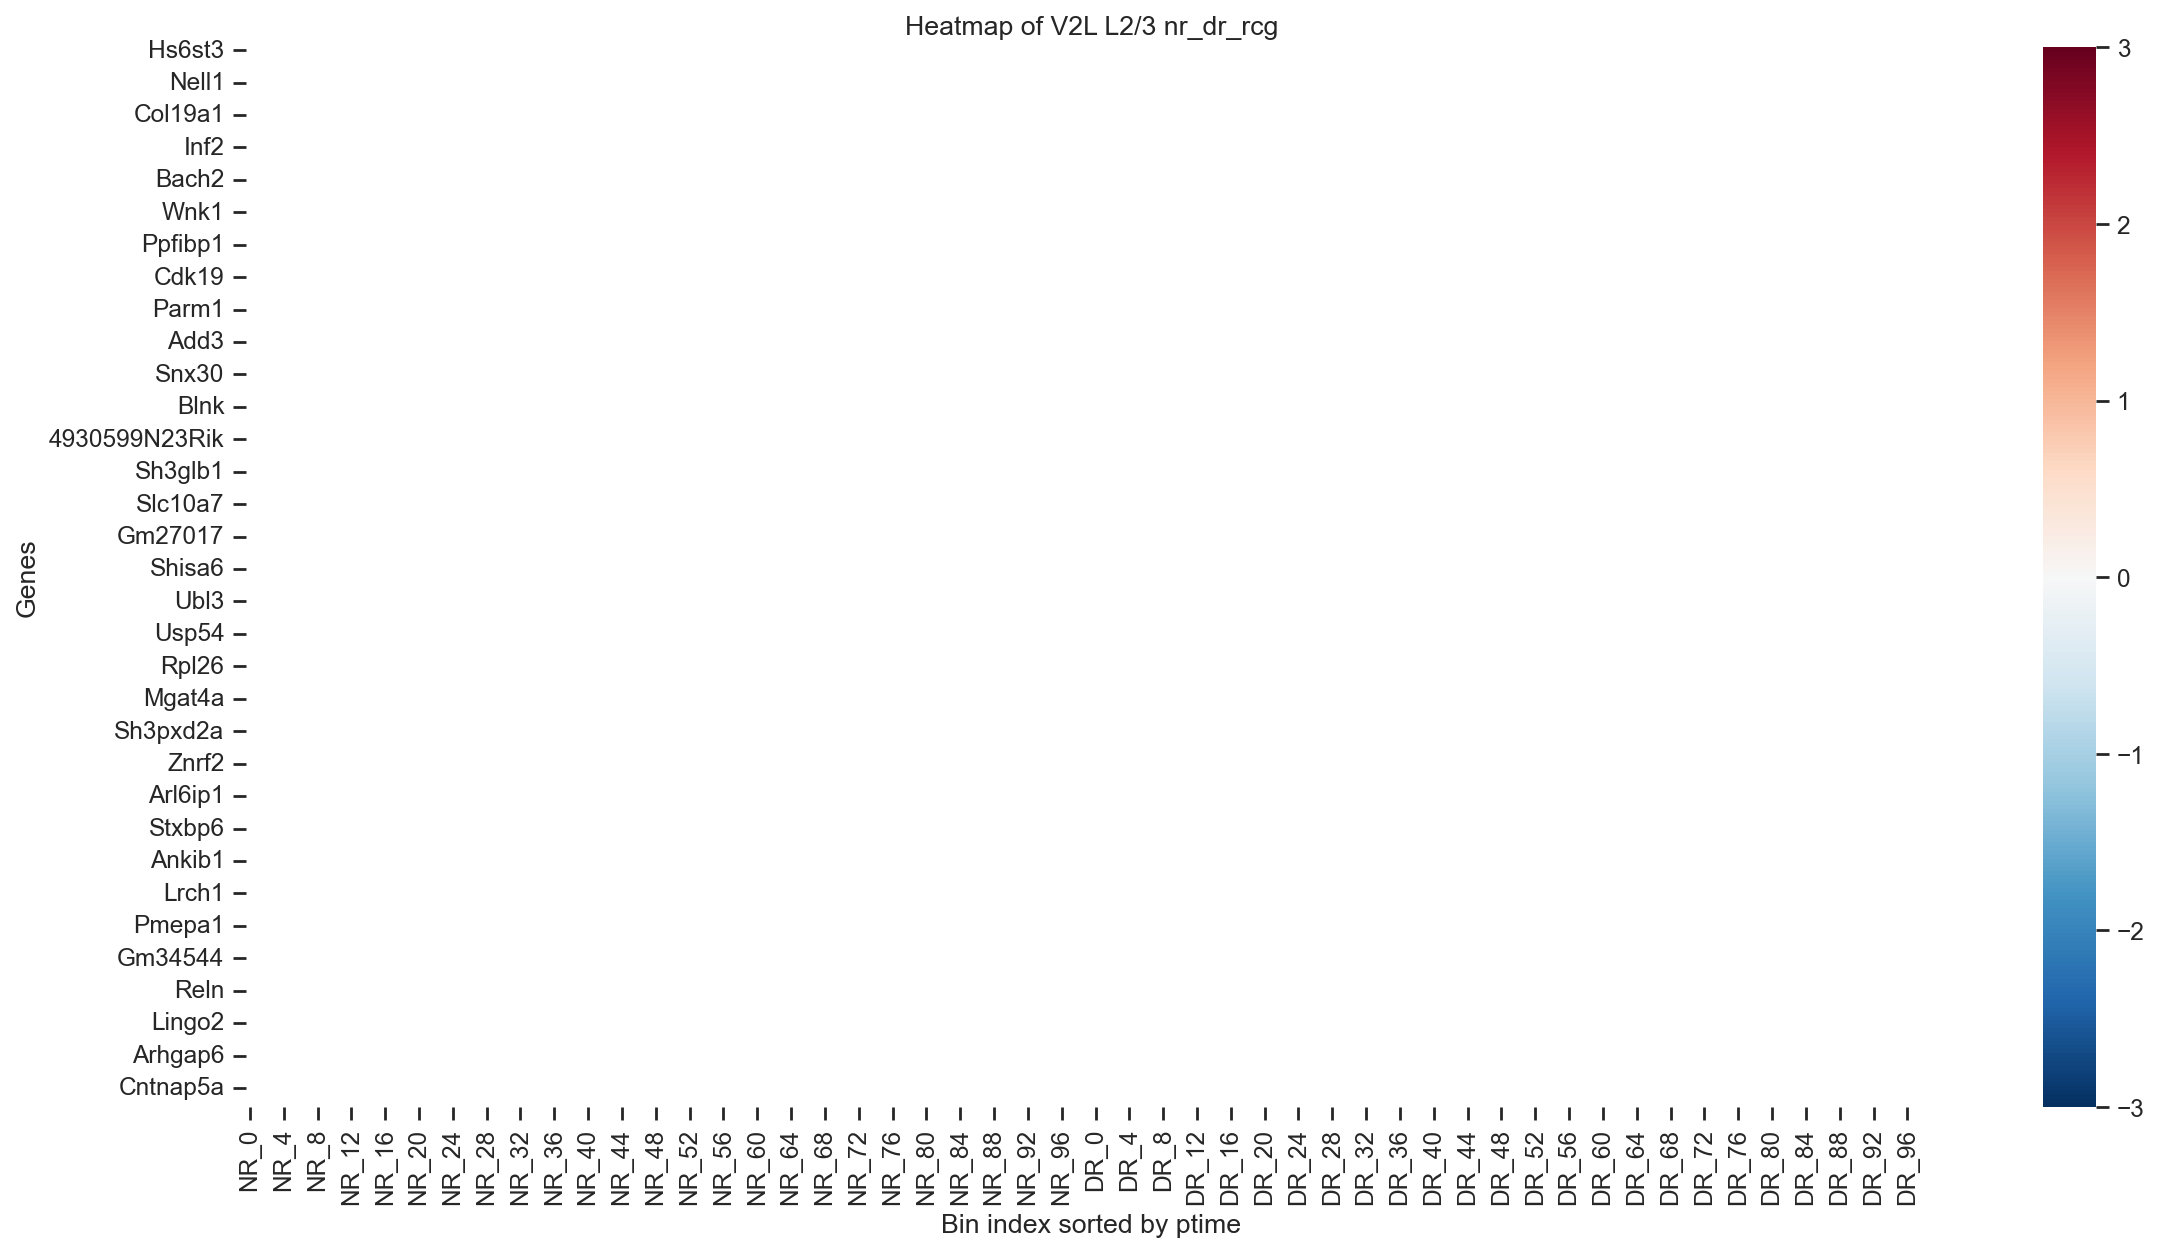

In [95]:

nr_rcg_sorted_slope = nr_rcg_sorted
dr_rcg_sorted_slope = dr_rcg_sorted
del nr_rcg_sorted_slope['slope']
del nr_rcg_sorted_slope['RCG']
del dr_rcg_sorted_slope['slope']
del dr_rcg_sorted_slope['RCG']
del dr_rcg_sorted_slope['RCG_order']


In [97]:
dr_rcg_sorted_slope

DR_0      DR_1      DR_2      DR_3      DR_4      DR_5  \
Hs6st3    3.411033  3.581137  3.526057  3.499050  3.354170  3.448829   
Cntnap2   3.776868  3.745732  3.502887  3.507192  3.415228  3.388668   
Unc5d     2.933089  2.906950  2.577697  2.823147  2.929016  2.735265   
Brinp3    1.782938  1.552847  1.599064  1.361801  1.167869  1.085610   
Kcnh5     1.686213  1.759681  1.932920  1.775344  1.718423  1.585873   
...            ...       ...       ...       ...       ...       ...   
Egfem1    2.819438  2.986993  2.718826  2.706440  2.801107  2.649477   
Cntnap5a  1.938965  2.092318  2.308779  2.294137  2.309580  2.537251   
Dpyd      0.000000  0.000000  0.183467  0.085103  0.052985  0.078649   
Gpc6      0.646047  0.933453  1.610100  1.620654  1.718357  1.638418   
Kirrel3   0.534344  0.751711  0.749835  0.900570  0.940040  1.043009   

              DR_6      DR_7      DR_8      DR_9  ...     DR_90     DR_91  \
Hs6st3    3.257808  3.375144  3.196559  3.382571  ...  2.251336  2.122784   
Cntnap2   3.503415  3.227378  3.152980  3.376352  ...  1.878483  1.989305   
Unc5d     2.854607  2.890719  2.886189  2.495379  ...  2.271728  1.984041   
Brinp3    0.803487  1.134768  1.006881  0.917008  ...  0.903299  0.645464   
Kcnh5     1.588081  1.623819  1.495589  1.436884  ...  0.298164  0.256111   
...            ...       ...       ...       ...  ...       ...       ...   
Egfem1    2.740681  2.665201  2.238890  2.567551  ...  2.430228  2.413020   
Cntnap5a  2.085572  2.482982  2.308829  2.366312  ...  2.437505  2.544392   
Dpyd      0.070960  0.070304  0.034949  0.067137  ...  1.847037  1.606665   
Gpc6      1.699894  1.842310  1.952405  1.987784  ...  2.903465  2.980715   
Kirrel3   1.040957  1.340198  1.070895  1.150935  ...  2.930517  2.935742   

             DR_92     DR_93     DR_94     DR_95     DR_96     DR_97  \
Hs6st3    2.109028  2.010528  1.744921  1.752522  1.836815  1.499616   
Cntnap2   2.141018  1.977612  1.789009  1.721557  1.889732  1.661270   
Unc5d     2.133097  2.237747  2.089547  2.223180  2.000194  2.068437   
Brinp3    0.808430  0.565910  1.034747  0.634562  0.554508  0.858062   
Kcnh5     0.384963  0.135871  0.065740  0.149770  0.268698  0.113816   
...            ...       ...       ...       ...       ...       ...   
Egfem1    2.530667  2.568353  2.066648  2.294097  2.306181  1.992079   
Cntnap5a  2.396350  2.539249  2.402021  2.110596  2.268636  2.043223   
Dpyd      1.932656  2.089808  1.975195  2.175089  2.309929  2.324573   
Gpc6      2.809741  2.725186  2.631684  2.503868  2.248927  1.963562   
Kirrel3   2.618793  2.799618  2.707738  2.642013  2.622051  2.529792   

             DR_98     DR_99  
Hs6st3    1.544760  1.311010  
Cntnap2   1.820623  1.767952  
Unc5d     2.235630  2.182401  
Brinp3    0.915942  0.834196  
Kcnh5     0.000000  0.154804  
...            ...       ...  
Egfem1    2.037706  2.089329  
Cntnap5a  2.003036  1.607204  
Dpyd      2.472199  2.485910  
Gpc6      1.669773  1.987891  
Kirrel3   2.610222  2.548916  

[196 rows x 100 columns]

In [98]:
merged_nr_dr_rcg_df

NR_0      NR_1      NR_2      NR_3      NR_4      NR_5  \
Hs6st3    3.578342  3.379573  3.490191  3.250511  3.284392  3.125900   
Cntnap2   3.515059  3.316636  3.107047  3.155781  3.004039  2.921926   
Unc5d     2.976042  3.093550  2.824728  3.001395  2.825282  2.827452   
Brinp3    2.089909  1.520473  1.742116  1.233706  1.777714  1.776037   
Kcnh5     1.445313  1.385048  1.237819  0.944813  1.012720  0.927245   
...            ...       ...       ...       ...       ...       ...   
Egfem1    2.491886  2.415109  2.187387  2.113825  1.871074  2.019739   
Cntnap5a  1.601186  1.259390  1.650473  1.899347  1.533036  1.638558   
Dpyd      0.031540  0.032406  0.024966  0.000000  0.102197  0.024313   
Gpc6      0.844936  0.966586  1.297168  0.876303  1.328639  1.632814   
Kirrel3   0.478805  0.796086  0.757737  0.599932  0.878158  0.703468   

              NR_6      NR_7      NR_8      NR_9  ...  DR_90  DR_91  DR_92  \
Hs6st3    3.231078  3.271540  3.306256  3.115592  ...    NaN    NaN    NaN   
Cntnap2   2.842646  2.760105  2.767750  2.609029  ...    NaN    NaN    NaN   
Unc5d     2.818488  2.949113  2.767466  2.975153  ...    NaN    NaN    NaN   
Brinp3    1.731408  1.450481  1.454794  1.611859  ...    NaN    NaN    NaN   
Kcnh5     0.967685  0.866239  0.903850  0.679280  ...    NaN    NaN    NaN   
...            ...       ...       ...       ...  ...    ...    ...    ...   
Egfem1    1.509795  1.823144  1.621716  1.543517  ...    NaN    NaN    NaN   
Cntnap5a  1.387400  1.306776  1.464899  1.462636  ...    NaN    NaN    NaN   
Dpyd      0.040830  0.000000  0.032623  0.136948  ...    NaN    NaN    NaN   
Gpc6      1.907603  1.505649  1.498258  1.304185  ...    NaN    NaN    NaN   
Kirrel3   0.735663  0.782388  1.089465  0.986481  ...    NaN    NaN    NaN   

          DR_93  DR_94  DR_95  DR_96  DR_97  DR_98  DR_99  
Hs6st3      NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Cntnap2     NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Unc5d       NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Brinp3      NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Kcnh5       NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...         ...    ...    ...    ...    ...    ...    ...  
Egfem1      NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Cntnap5a    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Dpyd        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Gpc6        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
Kirrel3     NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[196 rows x 200 columns]

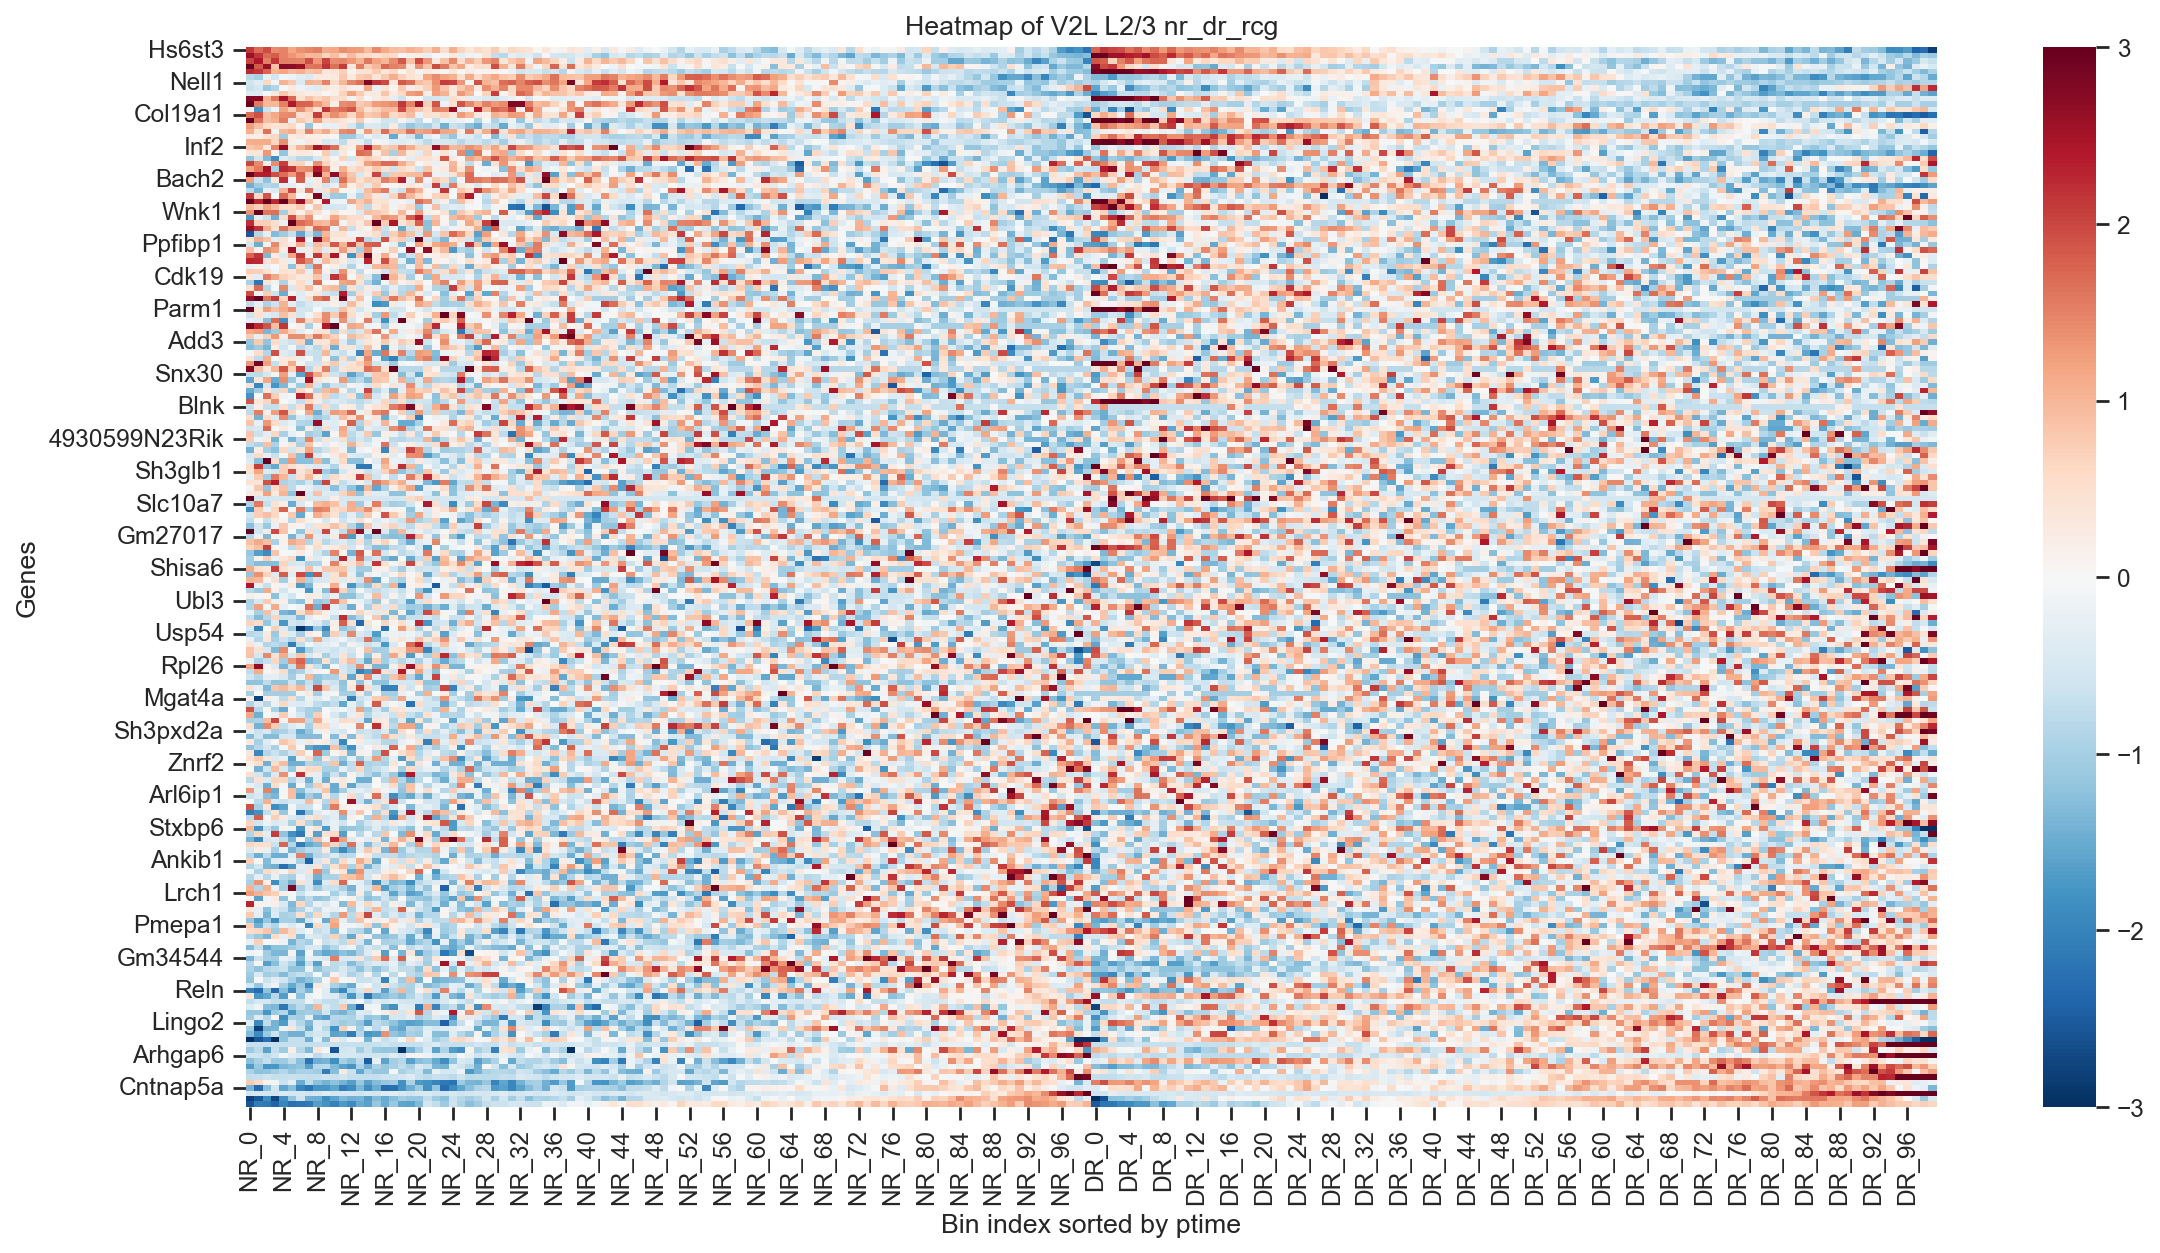

In [99]:
# 为df1和df2生成新的列名映射
columns_mapping1 = {i: 'NR_' + str(i) for i in range(100)}
columns_mapping2 = {i: 'DR_' + str(i) for i in range(100)}

# 使用rename方法重命名列
nr_rcg_sorted_slope = nr_rcg_sorted_slope.rename(columns=columns_mapping1)
dr_rcg_sorted_slope = dr_rcg_sorted_slope.rename(columns=columns_mapping2)

merged_nr_dr_rcg_df = nr_rcg_sorted_slope.join(dr_rcg_sorted_slope)
merged_nr_dr_rcg_df_zscore = merged_nr_dr_rcg_df.apply(zscore, axis=1)

# 使用 seaborn 绘制热图
plt.figure(figsize=(15,8))
sns.heatmap(merged_nr_dr_rcg_df_zscore, cmap='RdBu_r', fmt='.2f',vmin=-3,vmax=3)
plt.title('Heatmap of V2L L2/3 nr_dr_rcg')
plt.xlabel('Bin index sorted by ptime')
plt.ylabel('Genes')
plt.tight_layout()
# 显示图表
#plt.xticks(rotation=45, ha='right')  # 旋转X轴标签使其不重叠

# 显示热图
plt.savefig('Heatmap_of_V2L_L23_RCG.pdf')

In [100]:
# 按行计算方差
nr_rcg_sorted_slope['variance'] = nr_rcg_sorted_slope.apply(np.var, axis=1)
dr_rcg_sorted_slope['variance'] = dr_rcg_sorted_slope.apply(np.var, axis=1)
nr_non_rcg_sorted_slope['variance'] = nr_non_rcg_sorted_slope.apply(np.var, axis=1)
dr_non_rcg_sorted_slope['variance'] = dr_non_rcg_sorted_slope.apply(np.var, axis=1)

In [101]:
nr_dr_non_rcg_var = pd.DataFrame()
nr_dr_non_rcg_var['NR_var'] = list(nr_non_rcg_sorted_slope['variance'])
nr_dr_non_rcg_var['DR_var'] = list(dr_non_rcg_sorted_slope['variance'])
nr_dr_rcg_var = pd.DataFrame()
nr_dr_rcg_var['NR_var'] = list(nr_rcg_sorted_slope['variance'])
nr_dr_rcg_var['DR_var'] = list(dr_rcg_sorted_slope['variance'])

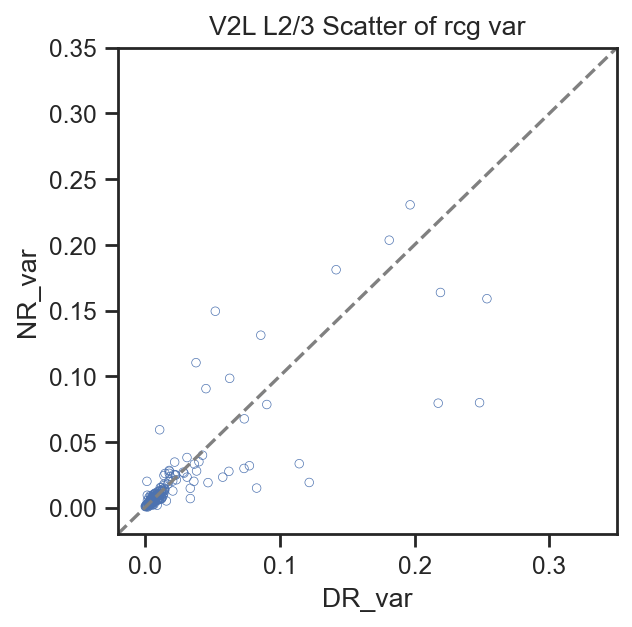

In [102]:
# 创建绘图区域和子图
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(data=nr_dr_rcg_var, x='DR_var', y='NR_var',s=15, marker='o', edgecolor='b', facecolor='none')
plt.title('V2L L2/3 Scatter of rcg var')
plt.xlim(-0.02,0.35)
plt.ylim(-0.02,0.35)
# 添加对角线虚线
limits = [-0.02,0.35]
ax.plot(limits, limits, linestyle='--', color='gray')
plt.savefig('V2L_L23_Scatter_of_rcg_var.pdf')

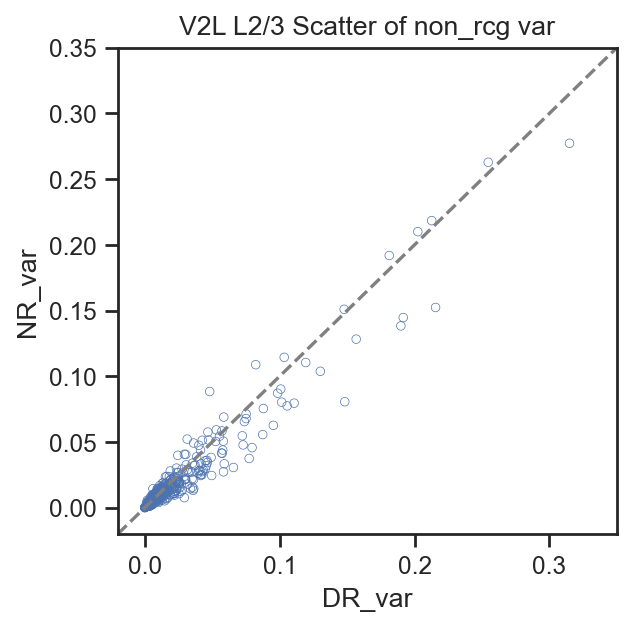

In [103]:
# 创建绘图区域和子图
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(data=nr_dr_non_rcg_var, x='DR_var', y='NR_var',s=15, marker='o', edgecolor='b', facecolor='none')
plt.title('V2L L2/3 Scatter of non_rcg var')
plt.xlim(-0.02,0.35)
plt.ylim(-0.02,0.35)
# 添加对角线虚线
limits = [-0.02,0.35]
ax.plot(limits, limits, linestyle='--', color='gray')
plt.savefig('V2L_L23_Scatter_of_non_rcg_var.pdf')

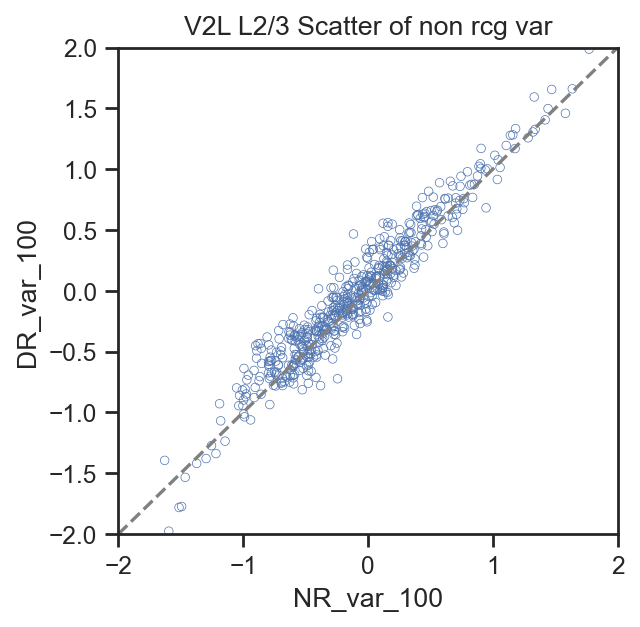

In [104]:
nr_dr_non_rcg_var['NR_var_100'] = np.log10(nr_dr_non_rcg_var['NR_var']*100)
nr_dr_non_rcg_var['DR_var_100'] = np.log10(nr_dr_non_rcg_var['DR_var']*100)
ax = sns.scatterplot(data=nr_dr_non_rcg_var, x='NR_var_100', y='DR_var_100',s=15, marker='o', edgecolor='b', facecolor='none')
plt.title('V2L L2/3 Scatter of non rcg var')
plt.xlim(-2,2)
plt.ylim(-2,2)
# 添加对角线虚线
limits = [-2,2]
ax.plot(limits, limits, linestyle='--', color='gray')
#plt.xscale('log')  # 对x轴进行对数缩放
#plt.yscale('log')  # 对y轴进行对数缩放
plt.savefig('V2L_L23_Scatter_of_non_rcg_var.pdf')

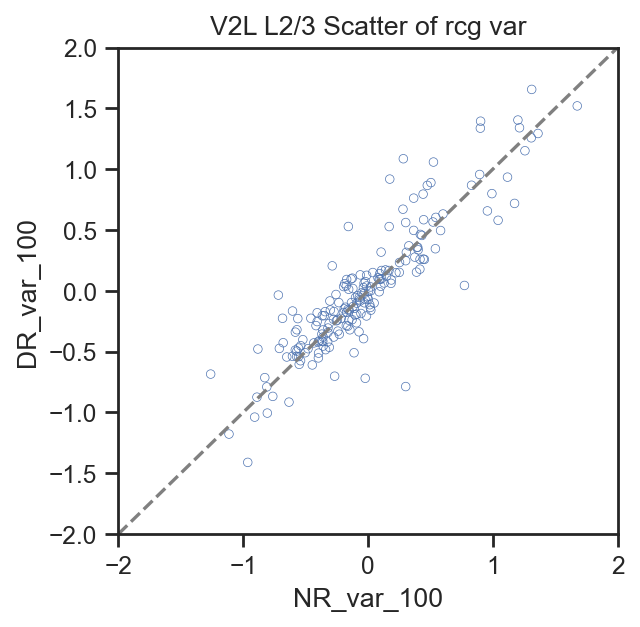

In [105]:
nr_dr_rcg_var['NR_var_100'] = np.log10(nr_dr_rcg_var['NR_var']*100)
nr_dr_rcg_var['DR_var_100'] = np.log10(nr_dr_rcg_var['DR_var']*100)
ax = sns.scatterplot(data=nr_dr_rcg_var, x='NR_var_100', y='DR_var_100',s=15, marker='o', edgecolor='b', facecolor='none')
plt.title('V2L L2/3 Scatter of rcg var')
plt.xlim(-2,2)
plt.ylim(-2,2)
# 添加对角线虚线
limits = [-2,2]
ax.plot(limits, limits, linestyle='--', color='gray')
#plt.xscale('log')  # 对x轴进行对数缩放
#plt.yscale('log')  # 对y轴进行对数缩放
plt.savefig('V2L_L23_Scatter_of_rcg_var.pdf')

In [107]:
from scipy.stats import pearsonr, spearmanr

In [108]:
x = np.array(nr_dr_non_rcg_var['DR_var'])
y = np.array(nr_dr_non_rcg_var['NR_var'])
valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
x = x[valid_indices]
y = y[valid_indices]
spearman_coef, spearman_p = spearmanr(x, y)
print(f"Spearman corr: {spearman_coef}, p-value: {spearman_p}")

Spearman corr: 0.9540229384910492, p-value: 2.125169897982242e-288


In [109]:
x = np.array(nr_dr_rcg_var['DR_var'])
y = np.array(nr_dr_rcg_var['NR_var'])
valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
x = x[valid_indices]
y = y[valid_indices]
spearman_coef, spearman_p = spearmanr(x, y)
print(f"Spearman corr: {spearman_coef}, p-value: {spearman_p}")

Spearman corr: 0.8839914255432747, p-value: 5.605419155420224e-66


In [110]:
x = np.array(nr_dr_non_rcg_slope['NR_slope_sign'])
y = np.array(nr_dr_non_rcg_slope['DR_slope_sign'])
valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
x = x[valid_indices]
y = y[valid_indices]
spearman_coef, spearman_p = spearmanr(x, y)
print(f"Spearman corr: {spearman_coef}, p-value: {spearman_p}")

Spearman corr: 0.9232934828722792, p-value: 1.800346917619612e-229


In [111]:
x = np.array(nr_dr_rcg_slope['NR_slope_sign'])
y = np.array(nr_dr_rcg_slope['DR_slope_sign'])
valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
x = x[valid_indices]
y = y[valid_indices]
spearman_coef, spearman_p = spearmanr(x, y)
print(f"Spearman corr: {spearman_coef}, p-value: {spearman_p}")

Spearman corr: 0.5689263600793696, p-value: 3.333114380804164e-18


In [3]:
pc_gene = pd.read_csv('V2L_L23_Lasso_PC1rank.xls',sep='\t')

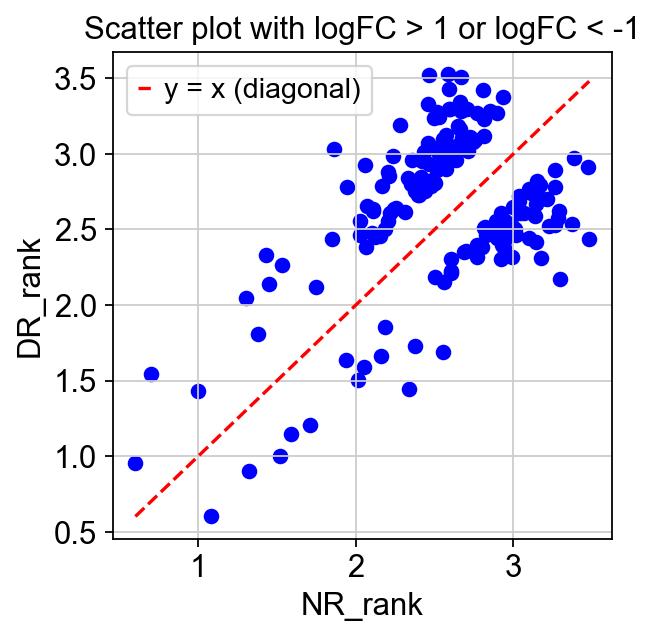

0.017671606845456548

In [4]:
# 1. 筛选 logFC > 1 或 logFC < -1 的基因
filtered_df = pc_gene[(pc_gene['logFC'] > 1) | (pc_gene['logFC'] < -1)]
filtered_df = filtered_df[(filtered_df['nr_pc_lasso'] != 4000) & (filtered_df['dr_pc_lasso'] != 4000)]
x = np.log10(filtered_df['nr_pc_lasso']+1)
y = np.log10(filtered_df['dr_pc_lasso']+1)

plt.scatter(x, y, color='b')
plt.plot([min(x), max(x)], [min(x), max(x)], 'r--', label='y = x (diagonal)')
plt.xlabel('NR_rank')
plt.ylabel('DR_rank')
plt.title('Scatter plot with logFC > 1 or logFC < -1')
plt.legend()
plt.show()

# 3. 计算每个点到对角线的距离
# 计算 y=x 的距离公式： |y - x| / sqrt(2)
log_distances = np.abs(y - x) / np.sqrt(2)

# 打印结果
filtered_df['log Distance_to_Diagonal'] = log_distances
variance_of_distances = np.var(log_distances)
variance_of_distances

In [5]:
filtered_df

Unnamed: 0        Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  \
1             1       Unc5c          590          248    0.421320 -1.247012   
3             3        Nfia          178          436    2.441341  1.287674   
8             8       Tead1          787          275    0.350254 -1.513527   
13           13      Picalm          349          843    2.411429  1.269888   
14           14       Ncoa3          571         1237    2.164336  1.113924   
..          ...         ...          ...          ...         ...       ...   
727         727  St6galnac3          105          289    2.735849  1.451989   
730         730      Arid1a          246          530    2.149798  1.104201   
733         733       Bach2          115          241    2.086207  1.060882   
738         738      Frmpd4         1504          203    0.135548 -2.883122   
742         742       Lrrn1          482          224    0.465839 -1.102098   

     NR_slope  NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
1   -0.001395      0.139527 -0.002331      0.233134         252.646941   
3    0.001236      0.123644  0.000772      0.077192         281.475942   
8    0.000414      0.041359  0.001126      0.112565         543.355124   
13   0.000363      0.036253 -0.000031      0.003079         592.347351   
14   0.000271      0.027060 -0.000077      0.007671         717.464452   
..        ...           ...       ...           ...                ...   
727 -0.003098      0.309791  0.001063      0.106337         123.818993   
730  0.001322      0.132250  0.000438      0.043786         265.040972   
733 -0.001826      0.182644 -0.001298      0.129781         198.586610   
738 -0.001494      0.149404 -0.002214      0.221377         237.659537   
742  0.000315      0.031453  0.001346      0.134622         650.107980   

     DR_predicted_rank  NR_predicted_rank_final  DR_predicted_rank_final  \
1           155.896836                    590.0                    248.0   
3           405.211725                    178.0                    436.0   
8           297.984636                    787.0                    275.0   
13         1770.742062                    349.0                    843.0   
14         1442.015769                    571.0                   1237.0   
..                 ...                      ...                      ...   
727         313.464338                    105.0                    289.0   
730         595.830662                    246.0                    530.0   
733         262.542161                    115.0                    241.0   
738         163.242773                   1504.0                    203.0   
742         254.123256                    482.0                    224.0   

     foldchange_predicted  logFC_predicted  subclassdeglogFC  \
1                0.421320        -1.247012          0.000000   
3                2.441341         1.287674          0.445133   
8                0.350254        -1.513527          0.414479   
13               2.411429         1.269888          0.000000   
14               2.164336         1.113924          0.000000   
..                    ...              ...               ...   
727              2.735849         1.451989         -0.236936   
730              2.149798         1.104201          0.388152   
733              2.086207         1.060882         -0.466184   
738              0.135548        -2.883122          0.311837   
742              0.465839        -1.102098          0.456286   

     log Distance_to_Diagonal  
1                    0.265439  
3                    0.274095  
8                    0.322170  
13                   0.270309  
14                   0.237110  
..                        ...  
727                  0.309071  
730                  0.235041  
733                  0.225820  
738                  0.613702  
742                  0.234593  

[165 rows x 18 columns]

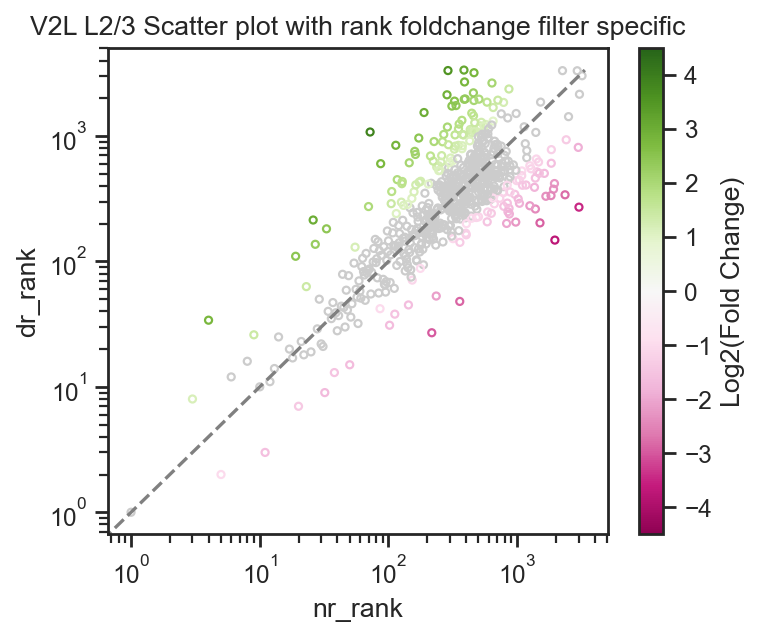

In [7]:
pc_gene_filter = pc_gene[(pc_gene['nr_pc_lasso'] != 4000) & (pc_gene['dr_pc_lasso'] != 4000)]
# 创建颜色映射条件
color_condition = (pc_gene_filter['logFC'] > -1) & (pc_gene_filter['logFC'] < 1)


# 设置 vmin 和 vmax 显式定义颜色范围
vmin, vmax = -4.5, 4.5

# 标准化颜色映射，确保 vmin 和 vmax 生效
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# 初始化所有点的颜色，根据 logFC 值进行颜色映射
colors = plt.cm.PiYG(norm(pc_gene_filter['logFC']))

# 将 gray_condition 和 color_condition 对应的点设置为灰色
#colors[gray_condition] = [0.5, 0.5, 0.5, 1.0]  # 灰色 (RGBA)
colors[color_condition] = [0.8, 0.8, 0.8, 1.0]  # 浅灰色 (RGBA)

# 创建绘图区域和子图
fig, ax = plt.subplots(figsize=(5,4))

# 绘制散点图，使用自定义颜色
scatter = ax.scatter(x=pc_gene_filter['nr_pc_lasso'], y=pc_gene_filter['dr_pc_lasso'], 
                     s=10,marker='o', edgecolor=colors, facecolor='none')

# 创建颜色映射对象，仅为非灰色的点设置颜色条
sm = plt.cm.ScalarMappable(cmap="PiYG", norm=norm)
sm.set_array(pc_gene_filter.loc[~color_condition, 'logFC'])  # 仅使用非灰色数据

# 添加颜色条
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Log2(Fold Change)')

# 添加对角线虚线
limits = [0, max(pc_gene_filter['nr_pc_lasso'].max(), pc_gene_filter['dr_pc_lasso'].max())]
ax.plot(limits, limits, linestyle='--', color='gray')

# 设置轴标签和标题
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('nr_rank')
ax.set_ylabel('dr_rank')
ax.set_title('V2L L2/3 Scatter plot with rank foldchange filter specific')

# 显示图形
plt.savefig('V2L_L23_Scatter_plot_with_rank_foldchange_filter_specific.pdf')

In [9]:
filtered_df = pd.read_csv('V2L_L23_Lasso_PC1rank_predict_sig.xls',sep='\t')

In [10]:
filtered_df

Unnamed: 0           Gene  nr_pc_lasso  dr_pc_lasso  foldchange  \
0             0          Unc5c          590          248    0.421320   
1             1           Nfia          178          436    2.441341   
2             2  4930599N23Rik         4000          339    0.084979   
3             3          Tead1          787          275    0.350254   
4             4         Lpgat1          531         4000    7.520677   
..          ...            ...          ...          ...         ...   
193         193     St6galnac3          105          289    2.735849   
194         194         Arid1a          246          530    2.149798   
195         195          Bach2          115          241    2.086207   
196         196         Frmpd4         1504          203    0.135548   
197         197          Lrrn1          482          224    0.465839   

        logFC  NR_slope  NR_slope_abs  DR_slope  DR_slope_abs  \
0   -1.247012 -0.001395      0.139527 -0.002331      0.233134   
1    1.287674  0.001236      0.123644  0.000772      0.077192   
2   -3.556754 -0.000216      0.021586 -0.000890      0.088986   
3   -1.513527  0.000414      0.041359  0.001126      0.112565   
4    2.910862  0.000173      0.017272 -0.000054      0.005441   
..        ...       ...           ...       ...           ...   
193  1.451989 -0.003098      0.309791  0.001063      0.106337   
194  1.104201  0.001322      0.132250  0.000438      0.043786   
195  1.060882 -0.001826      0.182644 -0.001298      0.129781   
196 -2.883122 -0.001494      0.149404 -0.002214      0.221377   
197 -1.102098  0.000315      0.031453  0.001346      0.134622   

     NR_predicted_rank  DR_predicted_rank  NR_predicted_rank_final  \
0           252.646941         155.896836               590.000000   
1           281.475942         405.211725               178.000000   
2           831.960981         367.869824               831.960981   
3           543.355124         297.984636               787.000000   
4           915.052632        1557.859980               531.000000   
..                 ...                ...                      ...   
193         123.818993         313.464338               105.000000   
194         265.040972         595.830662               246.000000   
195         198.586610         262.542161               115.000000   
196         237.659537         163.242773              1504.000000   
197         650.107980         254.123256               482.000000   

     DR_predicted_rank_final  foldchange_predicted  logFC_predicted  \
0                  248.00000              0.421320        -1.247012   
1                  436.00000              2.441341         1.287674   
2                  339.00000              0.408182        -1.292714   
3                  275.00000              0.350254        -1.513527   
4                 1557.85998              2.930188         1.550993   
..                       ...                   ...              ...   
193                289.00000              2.735849         1.451989   
194                530.00000              2.149798         1.104201   
195                241.00000              2.086207         1.060882   
196                203.00000              0.135548        -2.883122   
197                224.00000              0.465839        -1.102098   

     subclassdeglogFC false_positive  
0            0.000000             No  
1            0.445133             No  
2            0.688078             No  
3            0.414479             No  
4            0.348299             No  
..                ...            ...  
193         -0.236936             No  
194          0.388152             No  
195         -0.466184             No  
196          0.311837             No  
197          0.456286             No  

[198 rows x 18 columns]

In [11]:
filtered_df_1 = filtered_df[filtered_df['false_positive'] == 'No']

In [12]:
rcg_gene = list(filtered_df_1['Gene'])
rcg = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in rcg_gene:
        rcg.append('RCG')
    else:
        rcg.append('Non_RCG')
pc_gene['RCG'] = rcg

In [13]:
pc_gene['RCG'].value_counts()

RCG
Non_RCG    549
RCG        196
Name: count, dtype: int64

In [18]:
df_nr_ptime = pd.DataFrame( )
df_nr_ptime.index = nr.obs.index
df_nr_ptime['velocity_pseudotime'] = list(df_ptime_nr['velocity_pseudotime'])
df_nr_ptime['Celltype'] = nr.obs.Type
sns.displot(data=df_nr_ptime,x="velocity_pseudotime",hue="Celltype",kind="kde",palette=["#f29600","#4974a4","#b81316"],height=2,aspect=1)
plt.xlim(-1,1)
 
df_dr_ptime = pd.DataFrame( )
df_dr_ptime.index = dr.obs.index
df_dr_ptime['velocity_pseudotime'] = list(df_ptime_dr['velocity_pseudotime'])
df_dr_ptime['Celltype'] = dr.obs.Type
sns.displot(data=df_dr_ptime,x="velocity_pseudotime",hue="Celltype",kind="kde",palette=["#f29600","#4974a4","#b81316"],height=2,aspect=1)
plt.xlim(-1,1)

ValueError: Length of values (4238) does not match length of index (4324)

In [19]:
pc_gene

Unnamed: 0     Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  \
0             0    Nrbp2          291          386    1.325342  0.406365   
1             1    Unc5c          590          248    0.421320 -1.247012   
2             2   Kif13b          655          496    0.757622 -0.400450   
3             3     Nfia          178          436    2.441341  1.287674   
4             4  Fam210a          441          620    1.404977  0.490547   
..          ...      ...          ...          ...         ...       ...   
740         740   Tyrobp         2507         1428    0.569777 -0.811531   
741         741   Zfp608          110          134    1.216216  0.282400   
742         742    Lrrn1          482          224    0.465839 -1.102098   
743         743    Oprm1          241         4000   16.533058  4.047282   
744         744     Fbn2          435          286    0.658257 -0.603277   

     NR_slope  NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
0    0.000683      0.068280  0.000523      0.052253         391.226190   
1   -0.001395      0.139527 -0.002331      0.233134         252.646941   
2   -0.000177      0.017745  0.000384      0.038362         912.742584   
3    0.001236      0.123644  0.000772      0.077192         281.475942   
4    0.000678      0.067817 -0.000487      0.048660         392.975872   
..        ...           ...       ...           ...                ...   
740 -0.000020      0.002026  0.000085      0.008466        1118.082060   
741  0.002650      0.264957  0.002920      0.291968         142.393464   
742  0.000315      0.031453  0.001346      0.134622         650.107980   
743 -0.000581      0.058077 -0.001926      0.192584         434.994147   
744 -0.000960      0.095999 -0.001473      0.147275         312.950286   

     DR_predicted_rank  NR_predicted_rank_final  DR_predicted_rank_final  \
0           528.345085                    291.0               386.000000   
1           155.896836                    590.0               248.000000   
2           651.898857                    655.0               496.000000   
3           405.211725                    178.0               436.000000   
4           554.571983                    441.0               620.000000   
..                 ...                      ...                      ...   
740        1410.385256                   2507.0              1428.000000   
741         127.608040                    110.0               134.000000   
742         254.123256                    482.0               224.000000   
743         184.789973                    241.0               184.789973   
744         234.601801                    435.0               286.000000   

     foldchange_predicted  logFC_predicted  subclassdeglogFC      RCG  
0                1.325342         0.406365          0.000000  Non_RCG  
1                0.421320        -1.247012          0.000000      RCG  
2                0.757622        -0.400450          0.000000  Non_RCG  
3                2.441341         1.287674          0.445133      RCG  
4                1.404977         0.490547          0.000000  Non_RCG  
..                    ...              ...               ...      ...  
740              0.569777        -0.811531          0.000000  Non_RCG  
741              1.216216         0.282400          0.217387  Non_RCG  
742              0.465839        -1.102098          0.456286      RCG  
743              0.767727        -0.381334          0.410333  Non_RCG  
744              0.658257        -0.603277          0.486445  Non_RCG  

[745 rows x 18 columns]

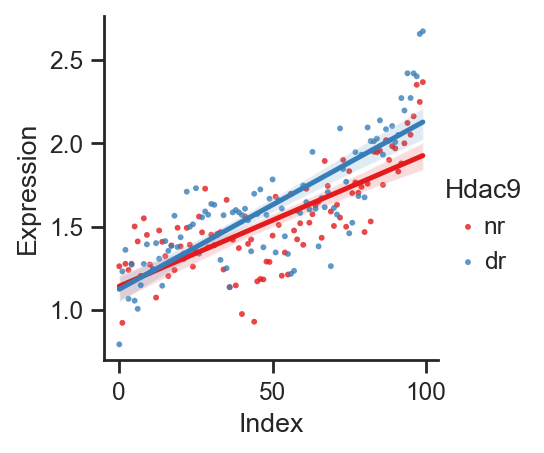

In [21]:
x = np.array(bin_means_nr['Hdac9'])
y = np.array(bin_means_dr['Hdac9'])
valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
x = x[valid_indices]
y = y[valid_indices]
df = pd.DataFrame()
df['nr'] = list(x)
df['dr'] = list(y)

df_long = pd.melt(df.reset_index(), id_vars='index', value_vars=['nr', 'dr'], 
                   var_name='Hdac9', value_name='Expression')

df_long.rename(columns={'index': 'Index'}, inplace=True)
sns.lmplot(data=df_long, x='Index', y='Expression', hue = 'Hdac9',scatter_kws=dict(s=7,edgecolor='none'),palette='Set1',height=3, aspect=1)

In [23]:
len(rcg)

745

In [26]:
pc_gene

Gene  nr_pc_lasso  dr_pc_lasso  foldchange     logFC  NR_slope  \
0      Nrbp2          291          386    1.325342  0.406365  0.000683   
1      Unc5c          590          248    0.421320 -1.247012 -0.001395   
2     Kif13b          655          496    0.757622 -0.400450 -0.000177   
3       Nfia          178          436    2.441341  1.287674  0.001236   
4    Fam210a          441          620    1.404977  0.490547  0.000678   
..       ...          ...          ...         ...       ...       ...   
740   Tyrobp         2507         1428    0.569777 -0.811531 -0.000020   
741   Zfp608          110          134    1.216216  0.282400  0.002650   
742    Lrrn1          482          224    0.465839 -1.102098  0.000315   
743    Oprm1          241         4000   16.533058  4.047282 -0.000581   
744     Fbn2          435          286    0.658257 -0.603277 -0.000960   

     NR_slope_abs  DR_slope  DR_slope_abs  NR_predicted_rank  \
0        0.068280  0.000523      0.052253         391.226190   
1        0.139527 -0.002331      0.233134         252.646941   
2        0.017745  0.000384      0.038362         912.742584   
3        0.123644  0.000772      0.077192         281.475942   
4        0.067817 -0.000487      0.048660         392.975872   
..            ...       ...           ...                ...   
740      0.002026  0.000085      0.008466        1118.082060   
741      0.264957  0.002920      0.291968         142.393464   
742      0.031453  0.001346      0.134622         650.107980   
743      0.058077 -0.001926      0.192584         434.994147   
744      0.095999 -0.001473      0.147275         312.950286   

     DR_predicted_rank  NR_predicted_rank_final  DR_predicted_rank_final  \
0           528.345085                    291.0               386.000000   
1           155.896836                    590.0               248.000000   
2           651.898857                    655.0               496.000000   
3           405.211725                    178.0               436.000000   
4           554.571983                    441.0               620.000000   
..                 ...                      ...                      ...   
740        1410.385256                   2507.0              1428.000000   
741         127.608040                    110.0               134.000000   
742         254.123256                    482.0               224.000000   
743         184.789973                    241.0               184.789973   
744         234.601801                    435.0               286.000000   

     foldchange_predicted  logFC_predicted  subclassdeglogFC      RCG  
0                1.325342         0.406365          0.000000  Non_RCG  
1                0.421320        -1.247012          0.000000      RCG  
2                0.757622        -0.400450          0.000000  Non_RCG  
3                2.441341         1.287674          0.445133      RCG  
4                1.404977         0.490547          0.000000  Non_RCG  
..                    ...              ...               ...      ...  
740              0.569777        -0.811531          0.000000  Non_RCG  
741              1.216216         0.282400          0.217387  Non_RCG  
742              0.465839        -1.102098          0.456286      RCG  
743              0.767727        -0.381334          0.410333  Non_RCG  
744              0.658257        -0.603277          0.486445  Non_RCG  

[745 rows x 17 columns]

In [25]:
del pc_gene['Unnamed: 0']

In [27]:
pc_gene.to_csv('V2L_L23_Lasso_PC1rank.xls',sep='\t')

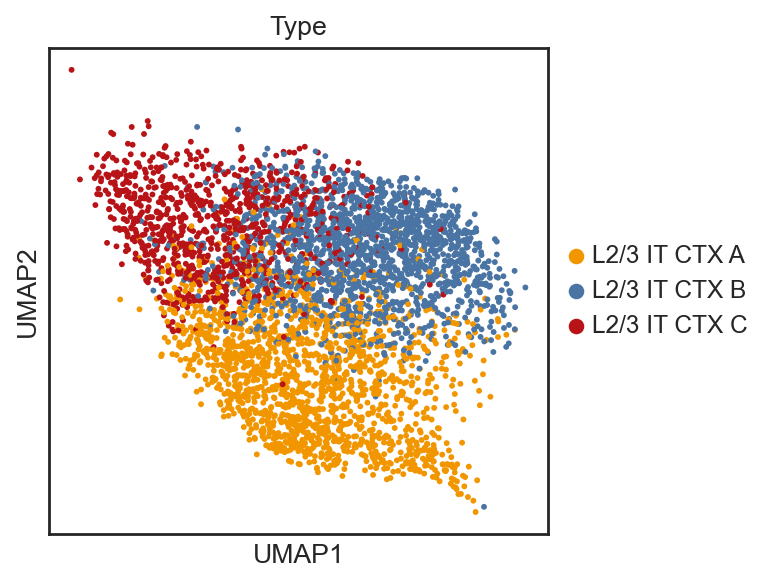

In [28]:
sc.pl.umap(nr, color='Type',palette=["#f29600","#4974a4","#b81316"])

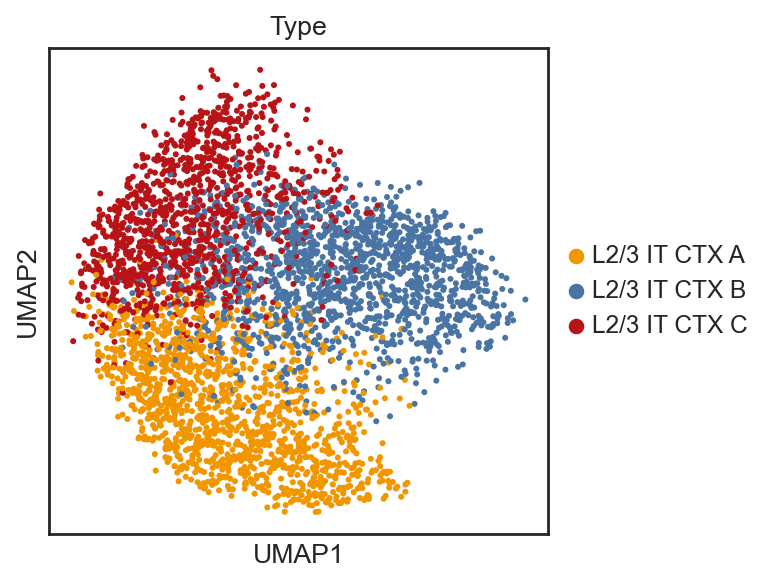

In [29]:
sc.pl.umap(dr, color='Type',palette=["#f29600","#4974a4","#b81316"])